## 1.Import 

In [56]:
import os
import pandas as pd
import gc
import sys
from pathlib import Path
import requests
import re
from bs4 import BeautifulSoup
from datetime import datetime
from IPython.display import Image


import warnings
warnings.filterwarnings("ignore")


# Get the absolute path to the 'utils' directory, which is assumed to be
# in the parent directory of the current Jupyter notebook's location.
utils_dir = str(Path.cwd().parent / "utils")

# Add the 'utils' directory to sys.path if it's not already included.
if utils_dir not in sys.path:
    sys.path.append(utils_dir)

# Import all functions from the '../utils/utils_v2.py' and  directory.
from utils_v2 import *

## 2. Read the data

In [57]:
os.listdir('../../Scraping_fbref_static_data/data/old_seasons')

['.DS_Store',
 'top5_leagues_keeper_2018_2019__2022_2023.csv',
 'top5_leagues_team_2018_2019__2022_2023.csv',
 'top5_leagues_team_vs_2018_2019__2022_2023.csv',
 'top5_leagues_outfields_2018_2019__2022_2023.csv']

In [58]:
os.listdir('../../Scraping_fbref_static_data/data/current_season')

['.DS_Store', '2024-03-08', '2024-03-06', '2024-03-02']

In [59]:
date = '2024-03-06'

os.listdir(f'../../Scraping_fbref_static_data/data/current_season/{date}')

['top5_leagues_team_vs_2023_2024.csv',
 'top5_leagues_team_2023_2024.csv',
 'top5_leagues_outfields_2023_2024.csv',
 'top5_leagues_keeper_2023_2024.csv']

In [60]:
path1 = '../../Scraping_fbref_static_data/data/old_seasons'
path2 = '../../Scraping_fbref_static_data/data/current_season'

In [61]:
#TOP5 europen leagues last 5 seasons
df_players_old = pd.read_csv('/'.join((path1, 'top5_leagues_outfields_2018_2019__2022_2023.csv')), index_col=0).reset_index(drop=True)
df_keeper_old = pd.read_csv('/'.join((path1, 'top5_leagues_keeper_2018_2019__2022_2023.csv')), index_col=0).reset_index(drop=True)
df_team_old = pd.read_csv('/'.join((path1, 'top5_leagues_team_2018_2019__2022_2023.csv')), index_col=0).reset_index(drop=True)
df_team_vs_old = pd.read_csv('/'.join((path1, 'top5_leagues_team_vs_2018_2019__2022_2023.csv')), index_col=0).reset_index(drop=True)

#TOP5 europen leagues current seasons (up-to-{date})
df_players = pd.read_csv('/'.join((path2, date, 'top5_leagues_outfields_2023_2024.csv')), index_col=0).reset_index(drop=True)
df_keeper = pd.read_csv('/'.join((path2, date, 'top5_leagues_keeper_2023_2024.csv')), index_col=0).reset_index(drop=True)
df_team = pd.read_csv('/'.join((path2, date, 'top5_leagues_team_2023_2024.csv')), index_col=0).reset_index(drop=True)
df_team_vs = pd.read_csv('/'.join((path2, date, 'top5_leagues_team_vs_2023_2024.csv')), index_col=0).reset_index(drop=True)


## 3. Calculate statistics

- calculate attack statistics + DA

In [62]:
# Function to perform the calculations on a dataframe
def process_team_dataframe(df):
    df['gk_passes_length_avg_m'] = round(df['gk_passes_length_avg'] * 0.9144,2)
    df['Shots on target%'] = round(df['shots_on_target_per90'] / df['shots_per90'] * 100,2)
    df['Passes to final 3rd%'] = round(df['passes_into_final_third'] / df['passes_completed'] * 100,2)
    df['Passes to PA'] = round(df['passes_into_penalty_area'] / df['games'],2)
    df['box crosses%'] = round(df['crosses_into_penalty_area'] /  df['passes_into_penalty_area'] *100,2)
    df['Carries to final 3rd%'] = round(df['carries_into_final_third'] / df['carries']*100,2)
    df['Carries to PA'] = round(df['carries_into_penalty_area'] / df['games'],2)
    df['Touches final 3rd%'] = round(df['touches_att_3rd'] / df['touches_live_ball']*100,2)
    df['npxg/Shot on target'] = round(df['npxg_per90'] / df['shots_on_target_per90'],2)
    df['xa_per90'] = round(df['pass_xa'] / df['games'],2)
    df['touches in PA'] = round(df['touches_att_pen_area'] / df['games'],2)
    #just for df with direct statistic
    if df['squad'][0].split(' ')[0] != 'vs':
        df['DA'] = df['tackles'] + df['challenge_tackles'] + df['interceptions'] + df['fouls']
#         df['gk_psxg_per90'] = round(df['gk_psxg'] / df['games'],2)

    return df

In [63]:
# Applying adjustments and processing
df_team = process_team_dataframe(df_team)
df_team_old = process_team_dataframe(df_team_old)

df_team_vs = process_team_dataframe(df_team_vs)
df_team_vs_old = process_team_dataframe(df_team_vs_old)

- calculate defensive statistics
    - <b>PPDA</b>

In [64]:
def calculate_PPDA(df_vs, df):
    
    df_vs_ = df_vs.copy()
    df_ = df.copy()
    
    df_vs_['squad'] = df_vs_['squad'].apply(lambda x: x.replace('vs ',''))
    df_['squad'] = df_['squad'].apply(lambda x: x.replace('vs ',''))

    
    cols_to_merge = ['squad','season','DA']
    
    if 'PPDA' not in df_vs_.columns:

        df_merged = pd.merge(df_vs_, df_[cols_to_merge], on=['squad','season'])

        df_merged['PPDA'] = round(df_merged['passes'] / df_merged['DA'],2)

        del df_, df_vs_
        df_, df_vs = pd.DataFrame(), pd.DataFrame()
        gc.collect()

        return df_merged

    else:
        return df_vs



In [65]:
df_team_vs = calculate_PPDA(df_team_vs, df_team)
df_team_vs_old = calculate_PPDA(df_team_vs_old, df_team_old)

- add gk_psxg_net_per90 to dfs with against statistic 

In [66]:
df_team_vs['gk_psxg_net_per90'] = df_team['gk_psxg_net_per90']
df_team = df_team.drop(['gk_psxg_net_per90'], axis=1)

df_team_vs_old['gk_psxg_net_per90'] = df_team_old['gk_psxg_net_per90']
df_team_old = df_team_old.drop(['gk_psxg_net_per90'], axis=1)

- calculate defensive statistics
    - <b>tackles_interceptions_adj_per90</b>

In [67]:
# Function to adjust tackles and interceptions
def adjust_tackles_interceptions(df):
    df['minutes_wo_ball'] = (100 - df['possession']) / 100 * df['games'] * 90
    df['minutes_exp'] = df['games'] * 90 / 2
    df['tackles_interceptions_adj'] = df['tackles_interceptions'] / df['minutes_wo_ball'] * df['minutes_exp']
    df['tackles_interceptions_adj_per90'] = round(df['tackles_interceptions_adj'] / df['games'], 2)
    return df

# # Adjusting tackles and interceptions for both current and old team data
df_team = adjust_tackles_interceptions(df_team)
df_team_old = adjust_tackles_interceptions(df_team_old)

cols = ['tackles_interceptions_adj_per90', 'squad', 'season']
df_team_vs = pd.merge(df_team_vs, df_team[cols], on =['squad','season'])
df_team_vs_old = pd.merge(df_team_vs_old, df_team_old[cols], on =['squad','season'])




## 4. Create a Colors Dictionary for Teams

- Assign default colors to the teams: one team with #004D98 and the other with #DB0030

In [68]:
color_dict = {'Manchester City':'#004D98',
              'Manchester Utd':'#DB0030',
              'Arsenal':'#DB0030',
              'Chelsea':'#004D98',
              'Liverpool':'#DB0030',
              'Atletico': '#DB0030',
              'Barcelona':'#004D98',
              'Real Madrid':'#004D98',
              'Atlético Madrid':'#004D98'}

## 5. Chose metrics for Radar

1. metrics_dict_{attack/def}: 

- A dictionary that maps column names to their corresponding abbreviations for display on an Attacking or Defending Radar chart. 
- The 'type' key in the dictionary specifies the direction of the range on the radar for each specific metric.


2. metrics_to_plot_{attack/def}: 

- A set containing the names of metrics that will be visualized on either an Attacking or Defending Radar chart.

In [69]:
metrics_dict_attack = {'xG'                    : {'m':'xg_per90', 'type':1},
                       'npxG'                  : {'m':'npxg_per90', 'type':1},
                       'Shots'                 : {'m':'shots_per90', 'type':1},
                       'npxG/Shot'             : {'m':'npxg_per_shot','type':1},
                       'G/Shot'                : {'m':'goals_per_shot','type':1},
                       'Shots on target%'      : {'m':'Shots on target%','type':1},
                       'Shots on target'       : {'m':'shots_on_target_per90','type':1},
                       'G/Shot on target'      : {'m':'goals_per_shot_on_target','type':1},
                       'Passes to final 3rd%'  : {'m':'Passes to final 3rd%','type':1},
                       'Passes to PA'          : {'m':'Passes to PA','type':1},
                       'box crosses%'          : {'m':'box crosses%','type':0},
                       'Carries to final 3rd%' : {'m':'Carries to final 3rd%','type':1},
                       'Carries to PA'         : {'m':'Carries to PA','type':1},
                       'Touches final 3rd%'    : {'m':'Touches final 3rd%','type':1},
                       'Gk passes length'      : {'m':'gk_passes_length_avg_m','type':0},
                       'npxg/Shot on target'   : {'m':'npxg/Shot on target','type':1},
                       'GCA'                   : {'m':'gca_per90','type':1},
                       'xA'                    : {'m':'xa_per90','type':1},
                       'touches in PA'         : {'m':'touches in PA','type':1}
                  }

metrics_to_plot_attack = ['npxG', 
                          'npxG/Shot',
                          'Shots',
                          'Shots on target', 
#                           'GCA', 
                          'xA', \
                          'Passes to PA', 
                          'Carries to PA', 
                          'touches in PA', 
                          'Gk passes length',
                          'box crosses%'
                  ]

metrics_dict_def =    {'xG C.'                    : {'m':'xg_per90', 'type':0},
                       'npxG C.'                  : {'m':'npxg_per90', 'type':0},
                       'Shots C.'                 : {'m':'shots_per90', 'type':0},
                       'npxG/Shot C.'             : {'m':'npxg_per_shot','type':0},
                       'G/Shot C.'                : {'m':'goals_per_shot','type':0},
                       'Shots on target% C.'      : {'m':'Shots on target%','type':0},
                       'Shots on target C.'       : {'m':'shots_on_target_per90','type':0},
                       'G/Shot on target C.'      : {'m':'goals_per_shot_on_target','type':0},
#                        'Passes to final 3rd%'  : {'m':'Passes to final 3rd%','type':1},
                       'Passes to PA C.'          : {'m':'Passes to PA','type':0},
#                        'box crosses%'          : {'m':'box crosses%','type':0},
#                        'Carries to final 3rd%' : {'m':'Carries to final 3rd%','type':1},
                       'Carries to PA C.'         : {'m':'Carries to PA','type':0},
#                        'Touches final 3rd%'    : {'m':'Touches final 3rd%','type':1},
#                        'Gk passes length'      : {'m':'gk_passes_length_avg_m','type':0},
                       'npxg/Shot on target C.'   : {'m':'npxg/Shot on target','type':0},
                       'GCA C.'                   : {'m':'gca_per90','type':0},
                       'xA C.'                    : {'m':'xa_per90','type':0},
                       'touches in PA C.'         : {'m':'touches in PA','type':0},
                       'PPDA'                           : {'m':'PPDA','type':0},
                       'Tackles + Intercep adj'         : {'m':'tackles_interceptions_adj_per90','type':1},
                       'PSxG - GA'                     : {'m':'gk_psxg_net_per90','type':1},

                  }
metrics_to_plot_def = [ 
                       'npxG C.',
                       'npxG/Shot C.',
                       'Shots C.',
                       'Shots on target C.', 
                       'xA C.', 
#                        'Passes to PA C.', 
#                        'Carries to PA C.', 
                       'touches in PA C.',
                       'PPDA',
                        'Tackles + Intercep adj',
                           'PSxG - GA'

]



In [70]:
dict_m = {'Attacking Radar':{'metric_dict':metrics_dict_attack,
                             'metric_to_plot':metrics_to_plot_attack},
         'Defending Radar':{'metric_dict':metrics_dict_def,
                             'metric_to_plot':metrics_to_plot_def}}

## 6. Create Radar (step-by-step guide)

### 6.1 Create folders for saving images

In [71]:
# date = str(pd.to_datetime(datetime.now()).date())

date = '2024-03-06'


if date not in os.listdir('../img'):
    os.mkdir(f'../img/{date}')
    os.mkdir(f'../img/{date}/stats_image')
    os.mkdir(f'../img/{date}/radar_image')

### 6.2 Choose teams, radar type, metric_dict, metric_to_plot

In [72]:
team1 = 'Barcelona'
team2 = 'Real Madrid'

rt = 'Attacking Radar'

metric_dict = dict_m[rt]['metric_dict']
metric_to_plot = dict_m[rt]['metric_to_plot']

### 6.3 Get DF with metrics

In [73]:
df_metrics = get_df_metrics(df_team, df_team_old, team1, team2, metric_dict, metric_to_plot)
df_metrics

Statistic_Barcelona  Statistic_Real Madrid       p5  \
games                           27.00                  27.00      NaN   
npxG                             2.07                   1.70   0.8445   
npxG/Shot                        0.14                   0.11   0.0800   
Shots                           15.67                  15.89   9.4200   
Shots on target                  5.85                   5.96   2.8990   
xA                               1.67                   1.32   0.5800   
Passes to PA                    11.33                  10.85   4.8900   
Carries to PA                    6.56                   8.37   2.3290   
touches in PA                   28.89                  31.19  14.3320   
Gk passes length                23.32                  24.23  42.8900   
box crosses%                    21.24                  16.38  43.9575   

                      p95  Barcelona_p  Real Madrid_p  
games                 NaN          NaN            NaN  
npxG               1.8200         98.0           91.0  
npxG/Shot          0.1300         99.0           83.0  
Shots             16.2985         91.0           93.0  
Shots on target    5.8400         95.0           96.0  
xA                 1.4555         98.0           91.0  
Passes to PA      11.6600         94.0           92.0  
Carries to PA      6.7265         94.0           99.0  
touches in PA     29.6680         94.0           96.0  
Gk passes length  22.4360         92.0           90.0  
box crosses%      14.9900         78.0           92.0

### 6.3 Transform DF for use in visualization

In [74]:
df_metrics_v2 = preprocessing_df_metric(df_metrics, df_team, rt)
df_metrics_v2

index_name       Real Madrid     1  Barcelona     2
90s played                27               27      
competition          La-Liga          La-Liga      
season             2023-2024        2023-2024      
                       value  perc      value  perc
npxG                     1.7  91.0       2.07  98.0
npxG/Shot               0.11  83.0       0.14  99.0
Shots                  15.89  93.0      15.67  91.0
Shots on target         5.96  96.0       5.85  95.0
xA                      1.32  91.0       1.67  98.0
Passes to PA           10.85  92.0      11.33  94.0
Carries to PA           8.37  99.0       6.56  94.0
touches in PA          31.19  96.0      28.89  94.0
Gk passes length       24.23  90.0      23.32  92.0
box crosses%           16.38  92.0      21.24  78.0

### 6.4 Work with style

In [75]:
image = metrics_to_image(df_metrics_v2, color_dict, rt, date)

In [76]:
os.listdir(f'../img/{date}/stats_image')

['Stats_Attacking_Radar_Real Madrid_Celta Vigo_2024-03-06_2023-2024.jpeg',
 'Stats_Defending_Radar_Getafe_Valencia_2024-03-06_2023-2024.jpeg',
 'Stats_Attacking_Radar_Real Madrid_Barcelona_2024-03-06_2023-2024.jpeg',
 'Stats_Defending_Radar_Real Madrid_Barcelona_2024-03-06_2023-2024.jpeg',
 'Stats_Defending_Radar_Athletic Club_Las Palmas_2024-03-06_2023-2024.jpeg',
 'Stats_Defending_Radar_Girona_Osasuna_2024-03-06_2023-2024.jpeg',
 'Stats_Attacking_Radar_Getafe_Valencia_2024-03-06_2023-2024.jpeg',
 'Stats_Attacking_Radar_Athletic Club_Las Palmas_2024-03-06_2023-2024.jpeg',
 'Stats_Defending_Radar_Barcelona_Mallorca_2024-03-06_2023-2024.jpeg',
 'Stats_Defending_Radar_Alavés_Rayo Vallecano_2024-03-06_2023-2024.jpeg',
 'Stats_Attacking_Radar_Girona_Osasuna_2024-03-06_2023-2024.jpeg',
 'Stats_Attacking_Radar_Barcelona_Mallorca_2024-03-06_2023-2024.jpeg',
 'Stats_Attacking_Radar_Betis_Villarreal_2024-03-06_2023-2024.jpeg',
 'Stats_Attacking_Radar_Sevilla_Almería_2024-03-06_2023-2024.jpeg',


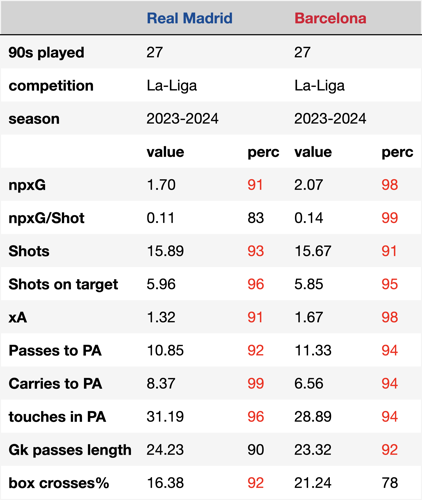

In [77]:
image_ = Image.open(f'../img/{date}/stats_image/Stats_Attacking_Radar_Real Madrid_Barcelona_2024-03-06_2023-2024.jpeg', )
size = (500, 500)
image_.thumbnail(size)
image_

### 6.5 Plotting Radar and Statistics

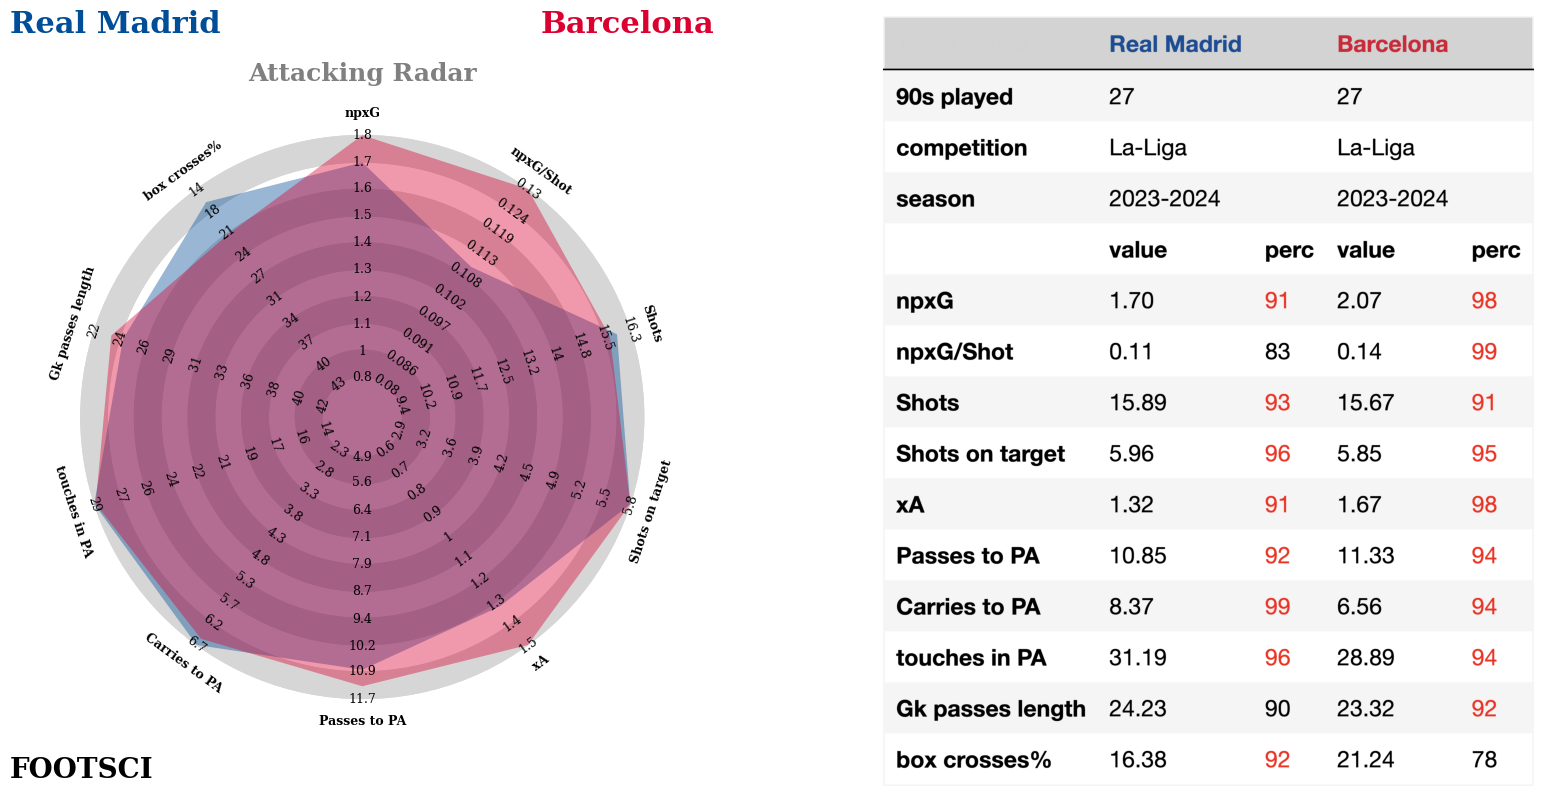

In [78]:
plot_radar(df_metrics, df_metrics_v2, rt, color_dict, date, image)


## 7. Encapsulate all actions in a loop

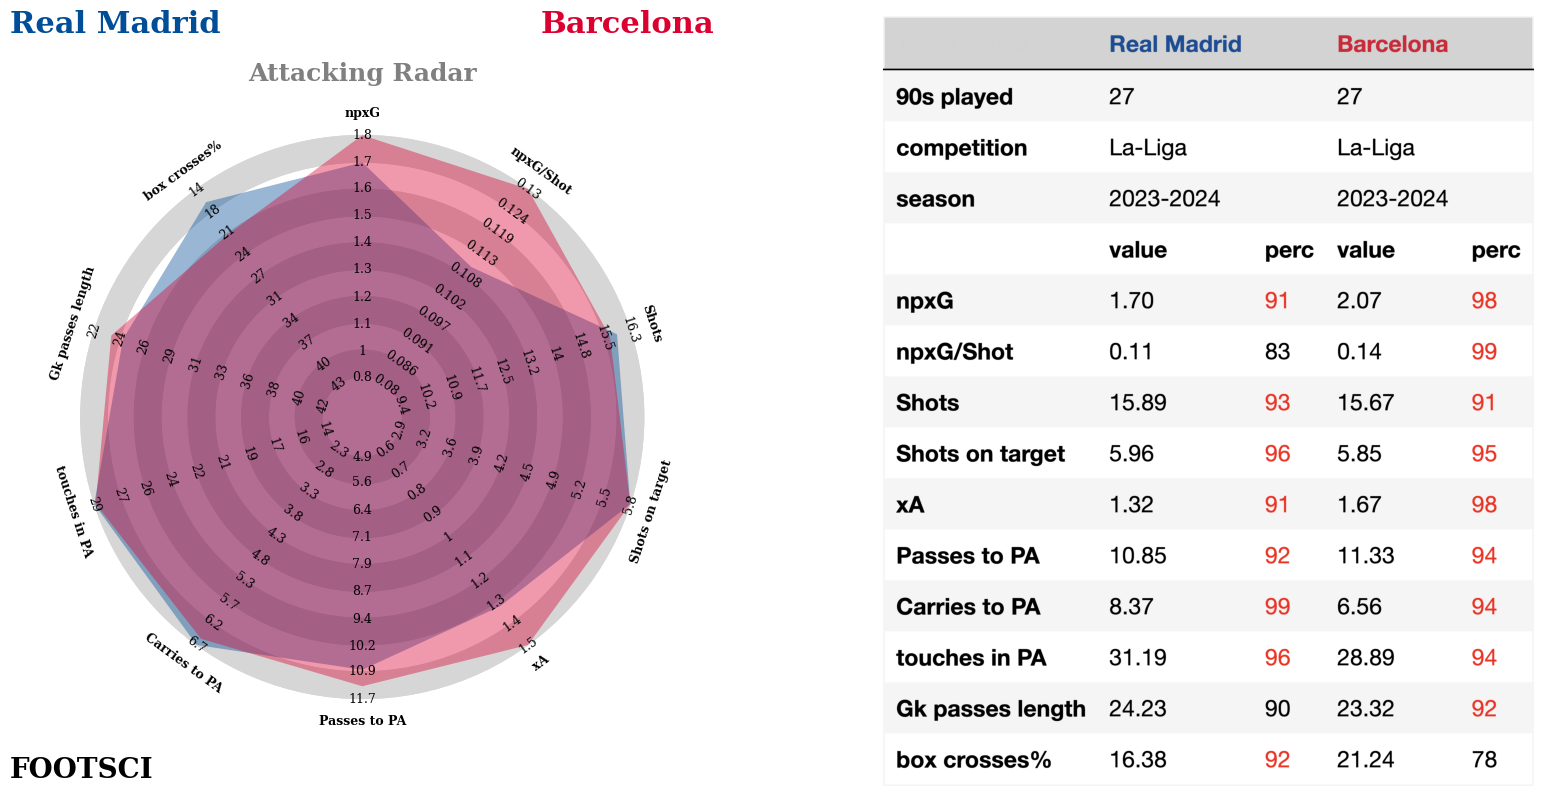

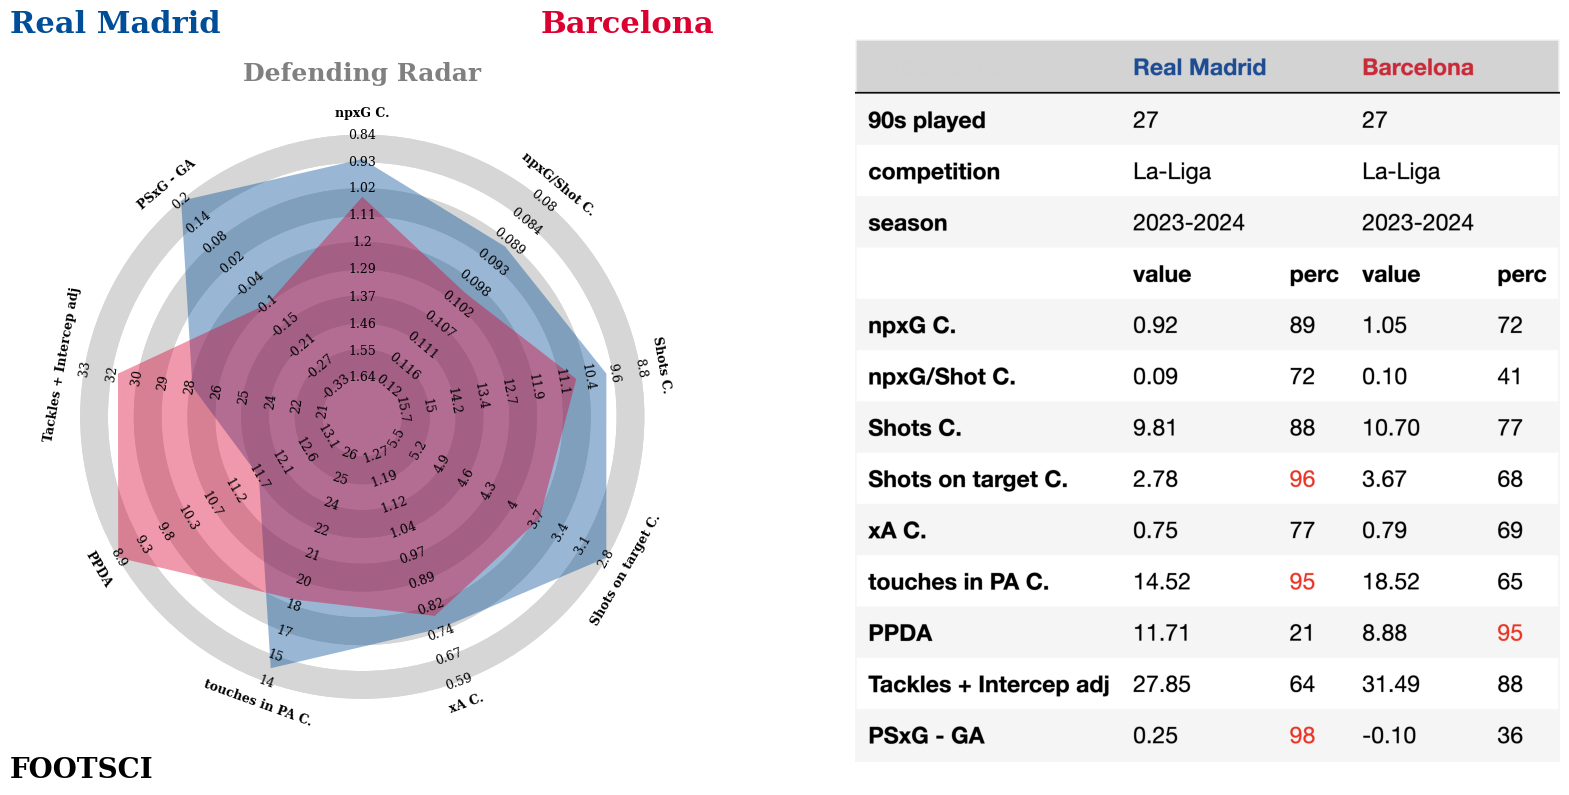

In [79]:
team1 = 'Barcelona'
team2 = 'Real Madrid'

radar_order = []

for rt in ['Attacking Radar', 'Defending Radar']:

    metric_dict = dict_m[rt]['metric_dict']
    metric_to_plot = dict_m[rt]['metric_to_plot']

    if rt == 'Attacking Radar':

        df_metrics = get_df_metrics(df_team, df_team_old, team1, team2, metric_dict, metric_to_plot)
        df_metrics_v2 = preprocessing_df_metric(df_metrics, df_team, rt)
        image = metrics_to_image(df_metrics_v2, color_dict, rt, date)
        plot_radar(df_metrics, df_metrics_v2, rt, color_dict, date, image)
        team1 = df_metrics_v2.columns[0]
        team2 = df_metrics_v2.columns[2]
        radar_order.append(team1)
        radar_order.append(team2)
    else:
        df_metrics = get_df_metrics(df_team_vs, df_team_vs_old, team1, team2, metric_dict, metric_to_plot)
        df_metrics_v2 = preprocessing_df_metric(df_metrics, df_team, rt, radar_order = radar_order)
        image = metrics_to_image(df_metrics_v2, color_dict, rt, date)
        plot_radar(df_metrics, df_metrics_v2, rt, color_dict, date, image, radar_order = radar_order)


## 8. Generate radar charts for all upcoming LaLiga matches in the next round

### 8.1 Scrape all tables from the 'Scores and Fixtures' page on fbref.com

In [80]:
league = 'La-Liga'
dict_league = {'La-Liga':12}

url = f'https://fbref.com/en/comps/{dict_league[league]}/schedule/{league}-Scores-and-Fixtures'

res = requests.get(url)
comm = re.compile("<!--|-->")
soup = BeautifulSoup(comm.sub("",res.text),'lxml')


tables_ = soup.findAll('table')

dict_res = {}

for t in tables_:
    
    attrs = t.attrs
    if 'id' in attrs:

        table_id = t.attrs['id']
        table_name = t.find('caption').text
        dict_res[table_id] ={'name': table_name,
                             'value':t.findAll('tbody')[0]}

### 8.2 Process the table containing the match schedule

In [81]:
table = dict_res['sched_2023-2024_12_1']['value']
features = get_column_names_from_table(table)


pre_df_squad = dict()
features_wanted_squad = features[1:]
rows_squad = table.find_all('tr')

for m, row in enumerate(rows_squad):
    if(row.find('th',{"scope":"row"}) != None):
        name = row.find('th',{"data-stat":"gameweek"}).text.strip().encode().decode("utf-8")
        if 'gameweek' in pre_df_squad:
            pre_df_squad['gameweek'].append(name)
        else:
            pre_df_squad['gameweek'] = [name]
            
        for n, f in enumerate(features_wanted_squad):

            cell = row.find("td",{"data-stat": f})
            a = cell.text.strip().encode()
            text=a.decode("utf-8")
            try:
                text = float(text.replace(',',''))
            except Exception as e:
                pass
            if f in pre_df_squad:
                pre_df_squad[f].append(text)
            else:
                pre_df_squad[f] = [text]
df_result = pd.DataFrame.from_dict(pre_df_squad)


### 8.3 Select matches for the upcoming round

In [82]:
mask = df_result['gameweek'] == '28'
df_games = df_result[mask][['home_team','away_team','date']].reset_index(drop=True)
df_games

home_team        away_team        date
0    Barcelona         Mallorca  2024-03-08
1     Valencia           Getafe  2024-03-09
2        Cádiz  Atlético Madrid  2024-03-09
3      Granada    Real Sociedad  2024-03-09
4       Girona          Osasuna  2024-03-09
5       Alavés   Rayo Vallecano  2024-03-10
6   Las Palmas    Athletic Club  2024-03-10
7  Real Madrid       Celta Vigo  2024-03-10
8        Betis       Villarreal  2024-03-10
9      Almería          Sevilla  2024-03-11

### 8.4 Create and store radar charts for each selected match

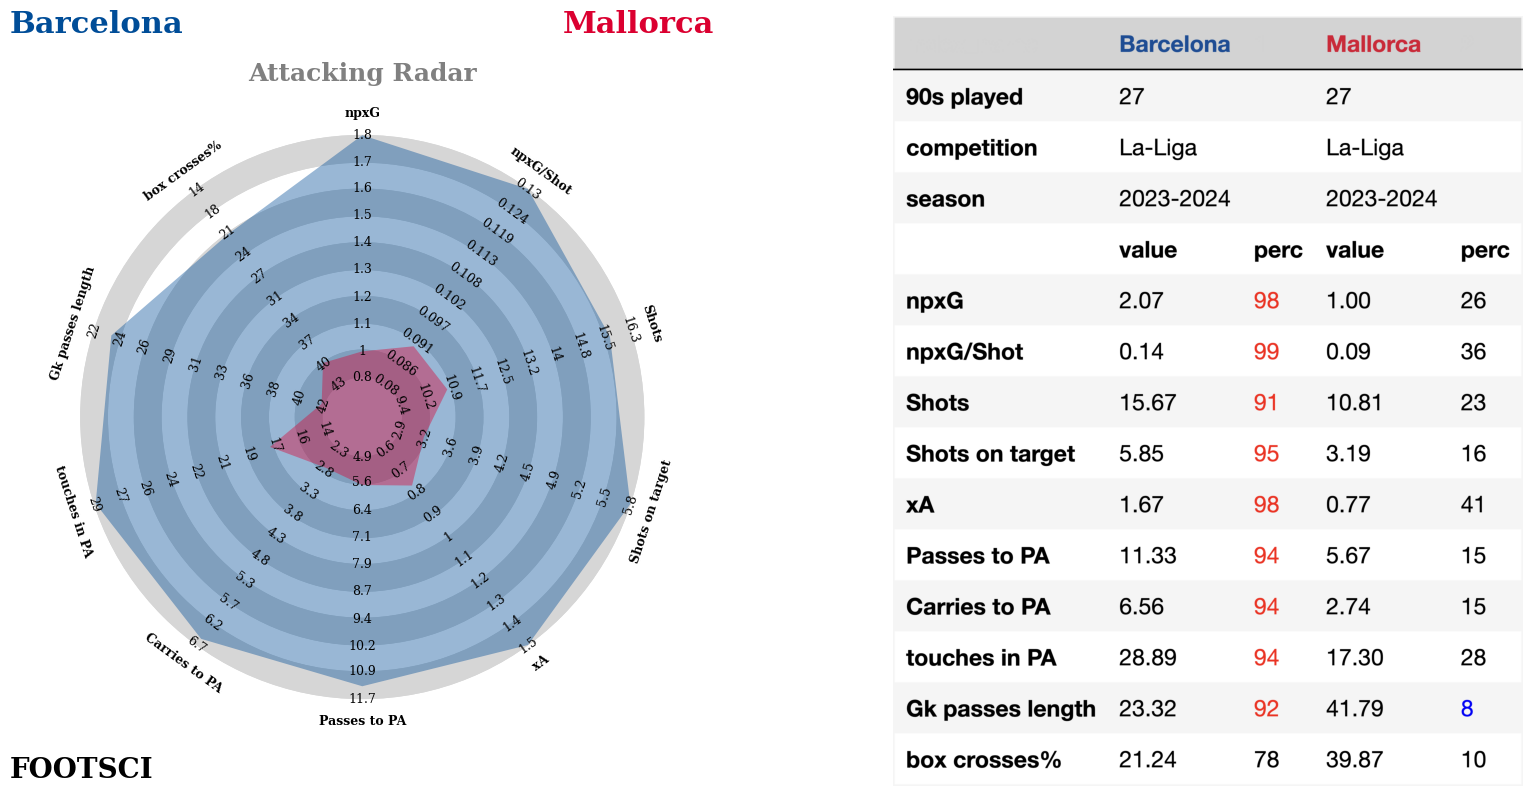

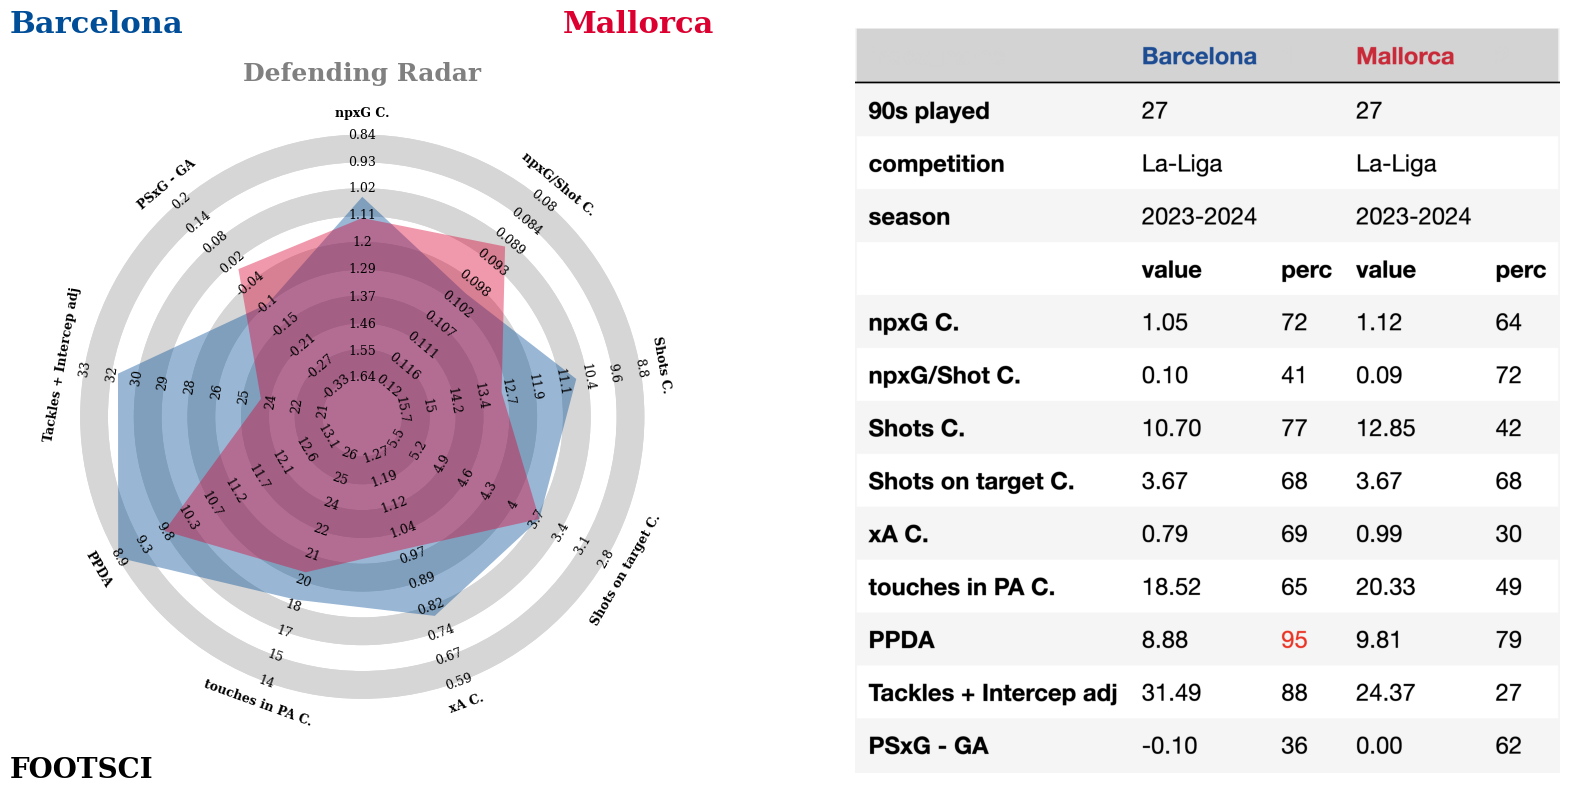

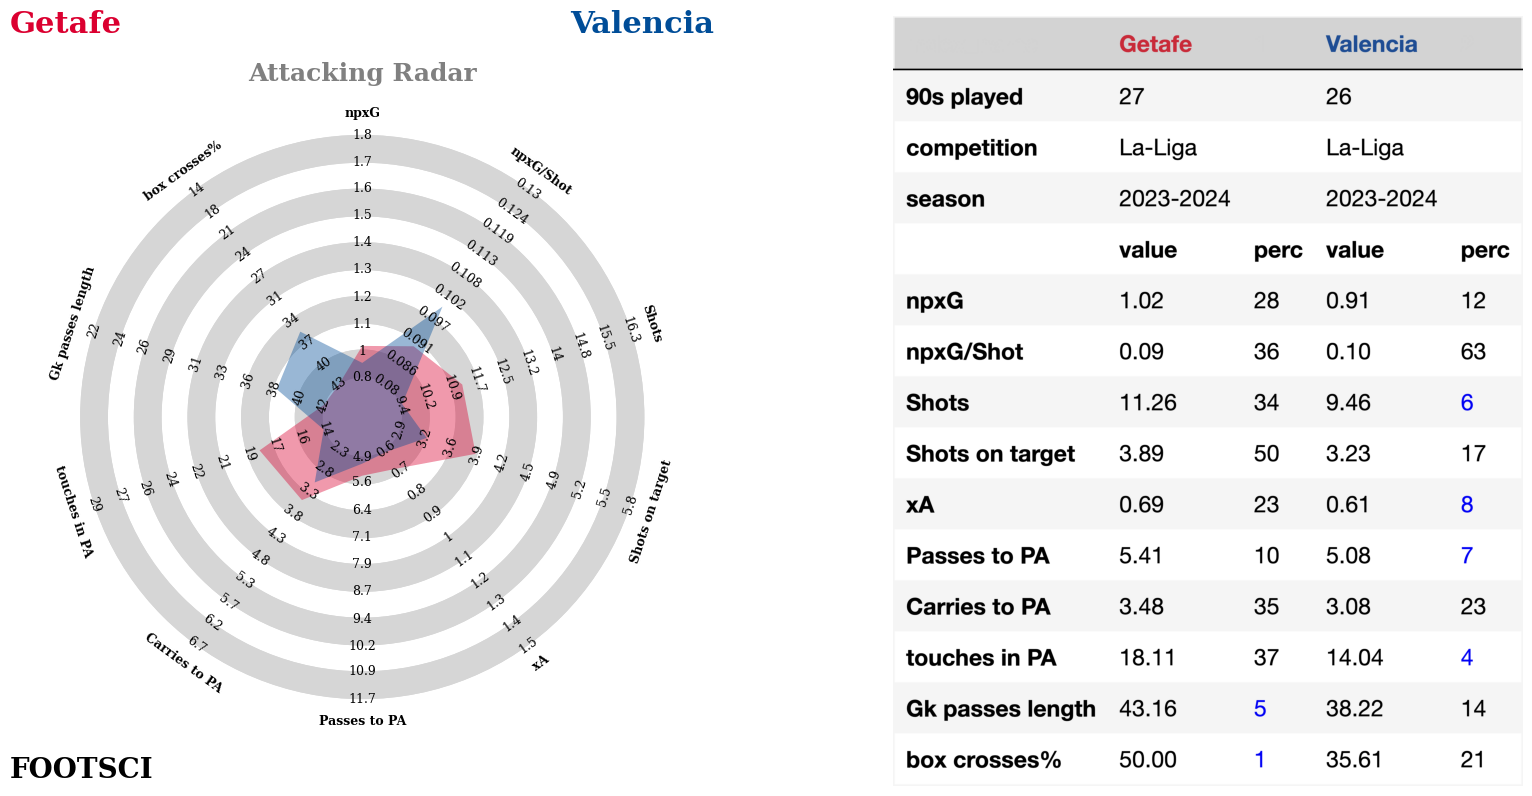

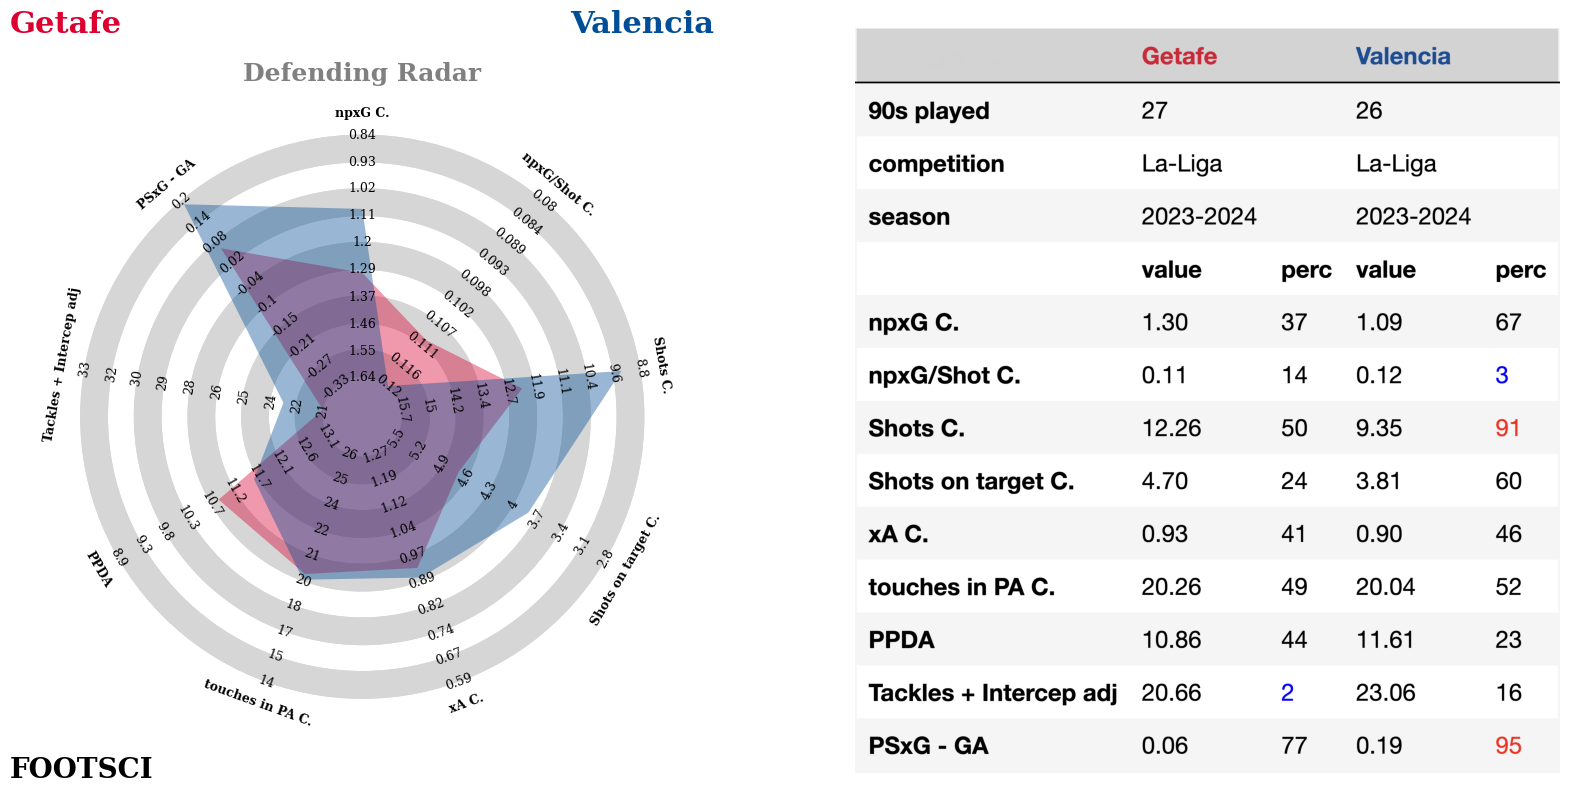

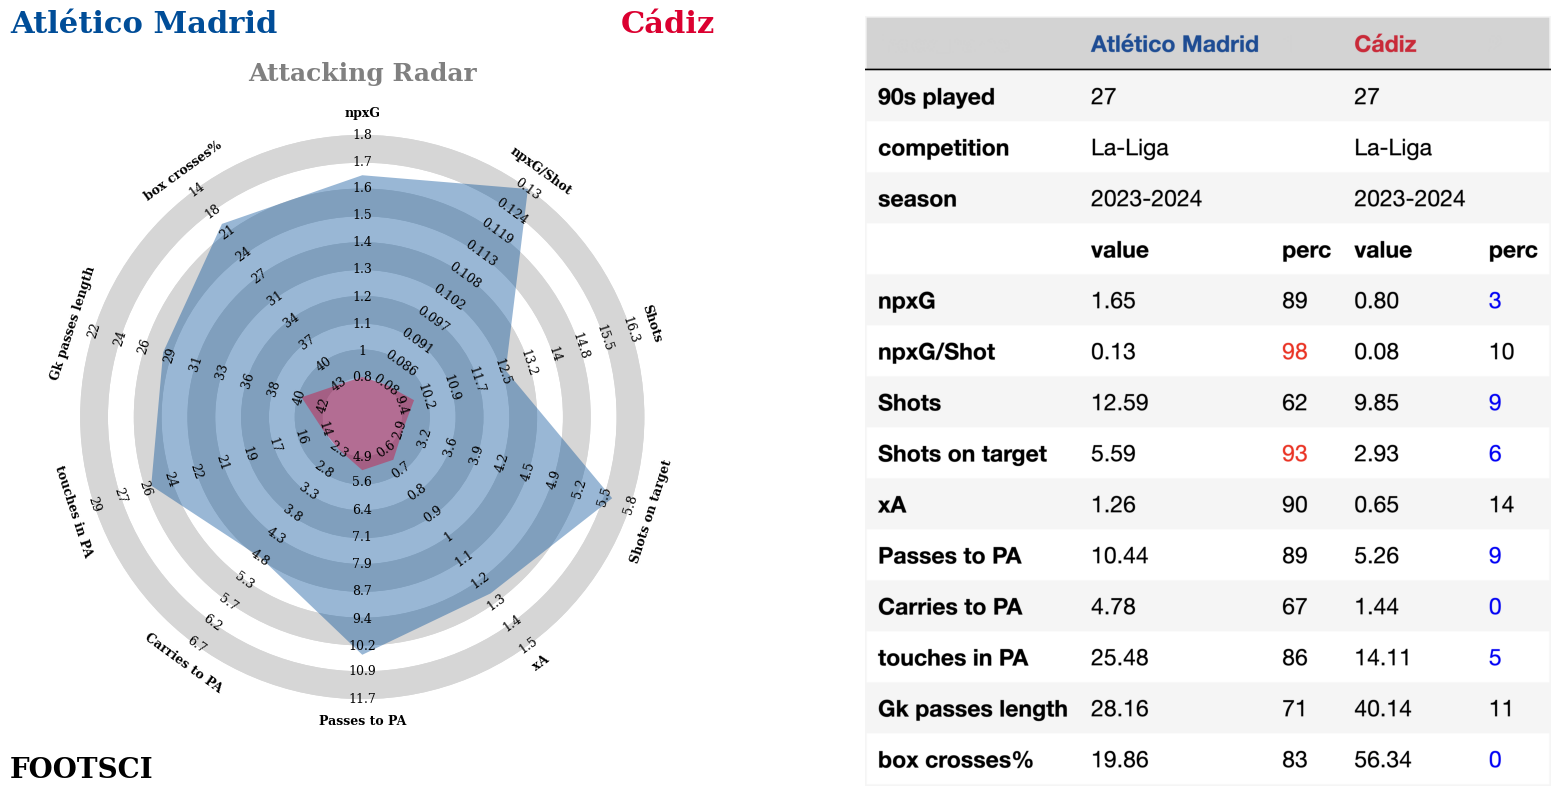

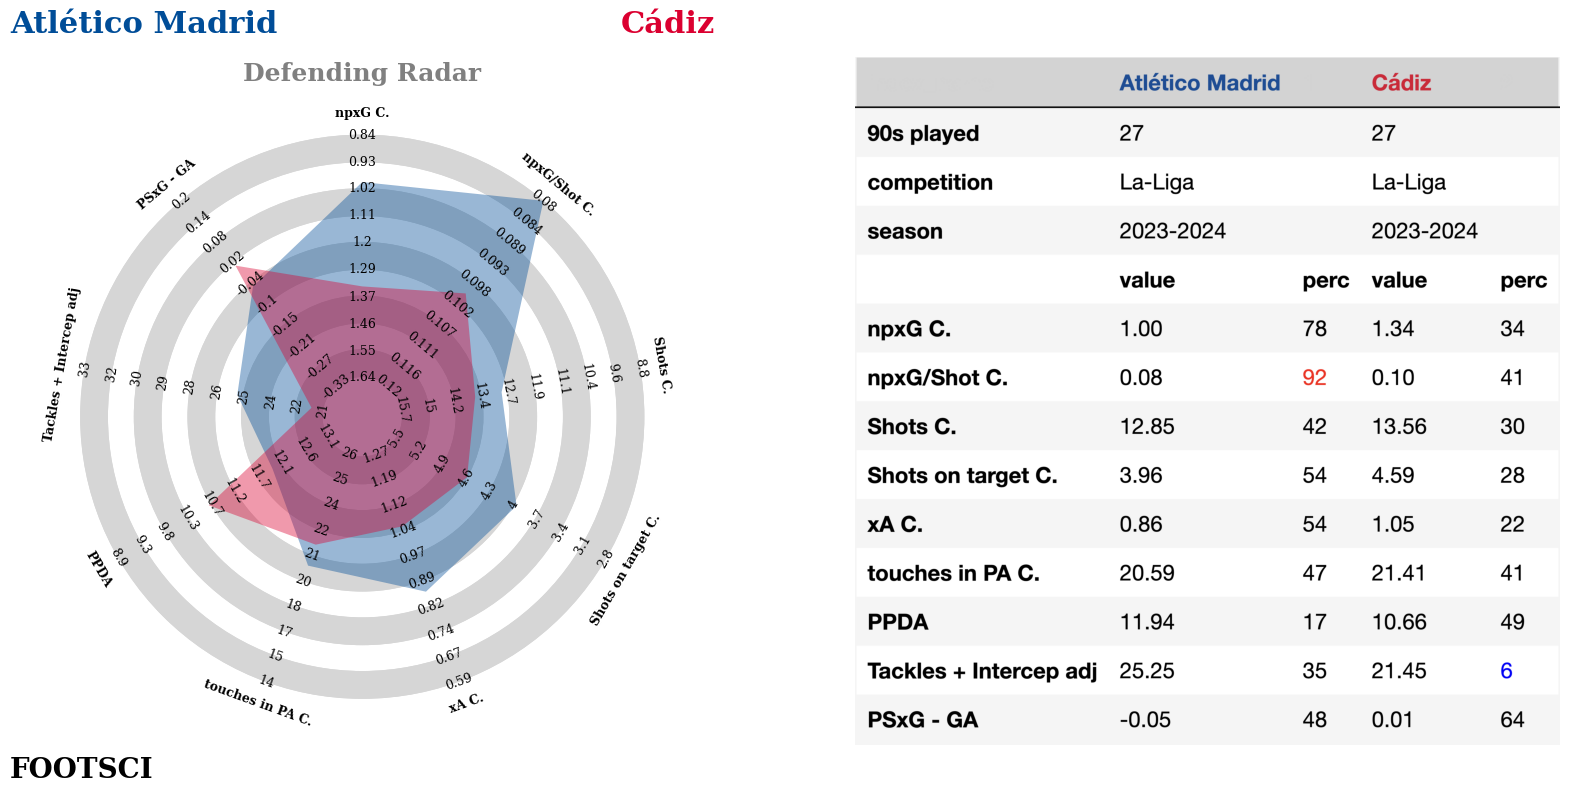

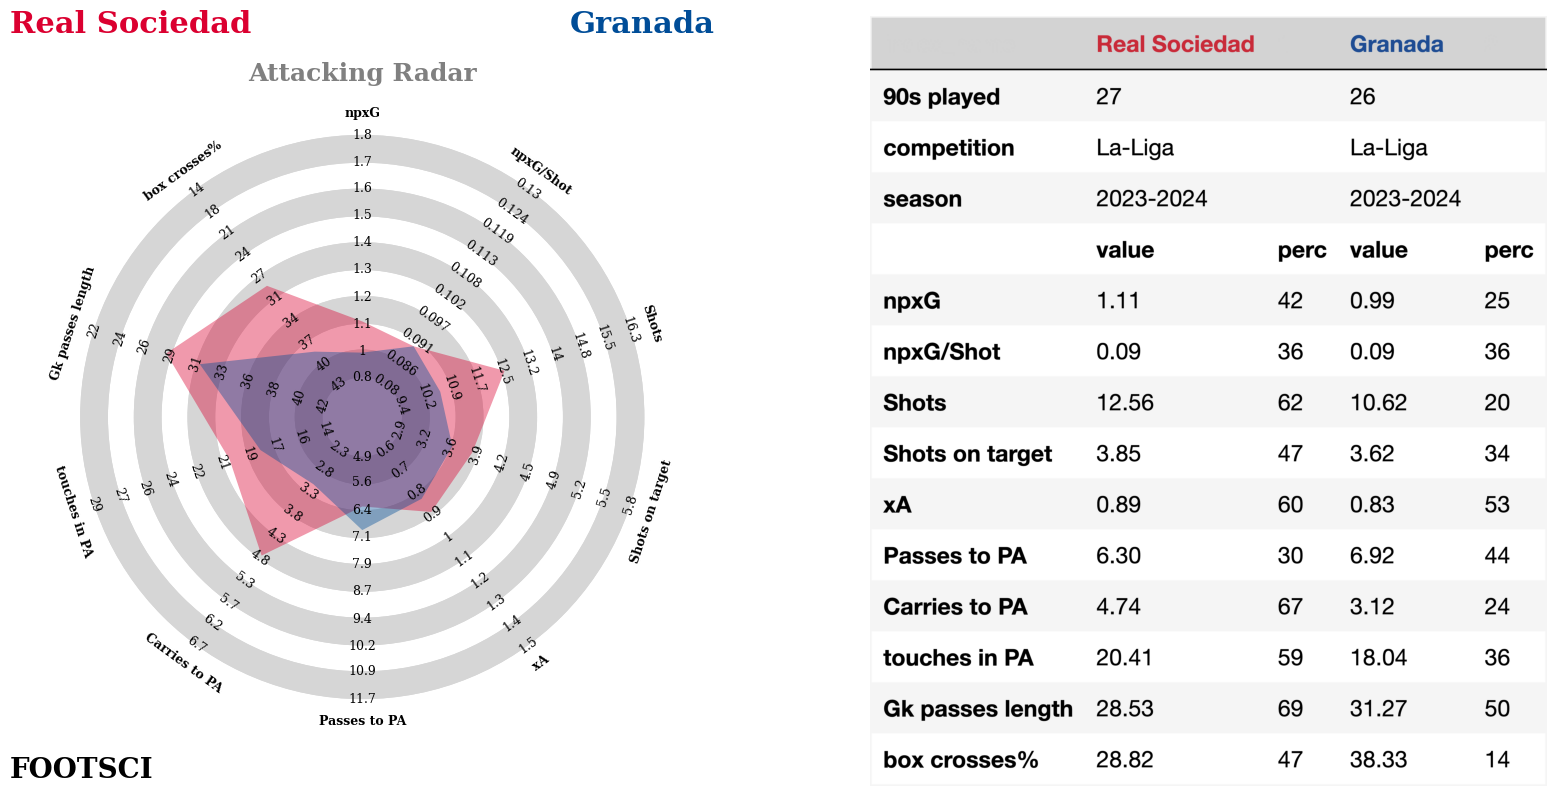

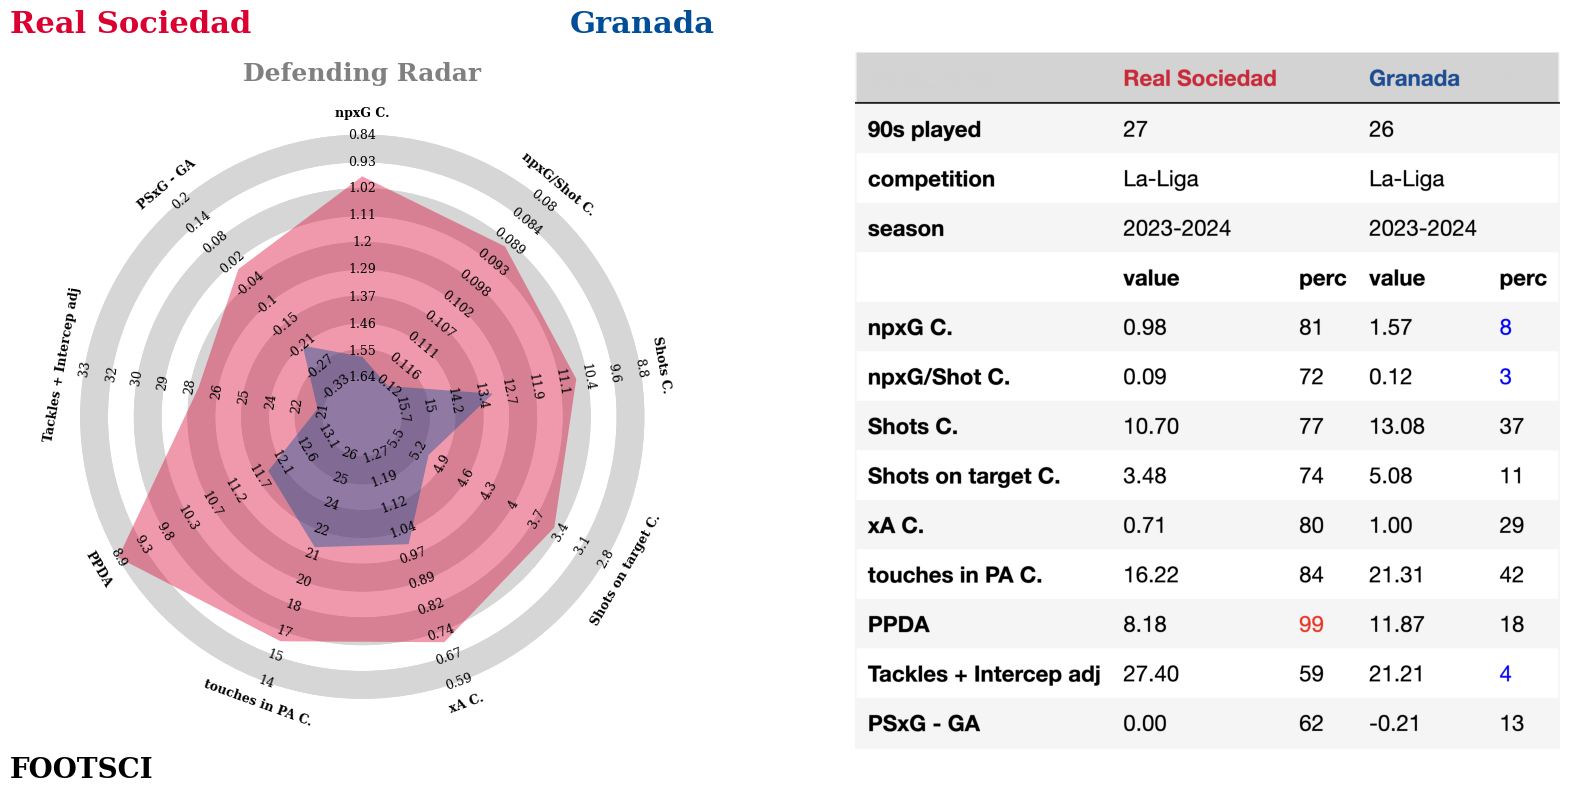

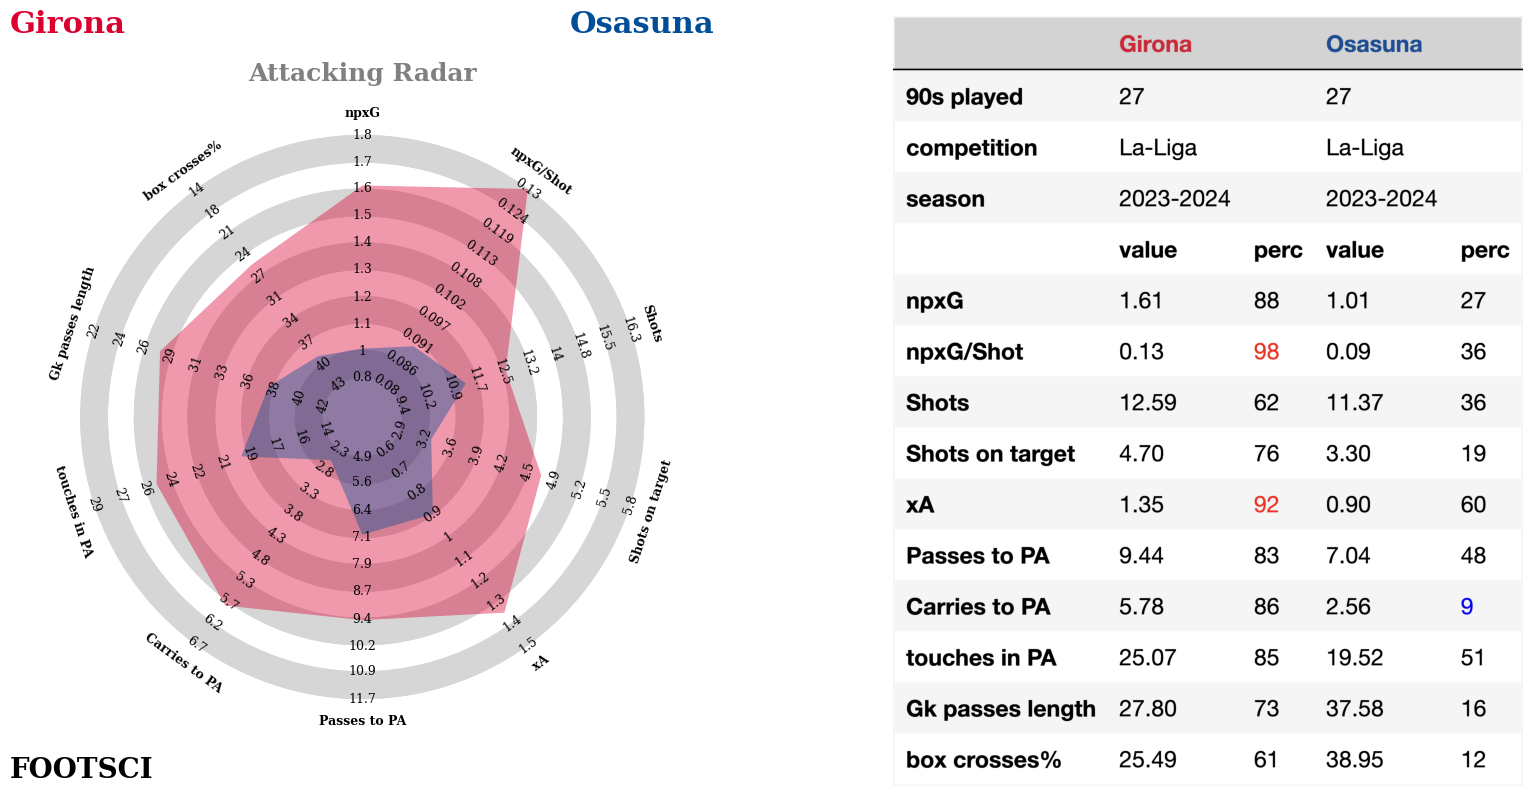

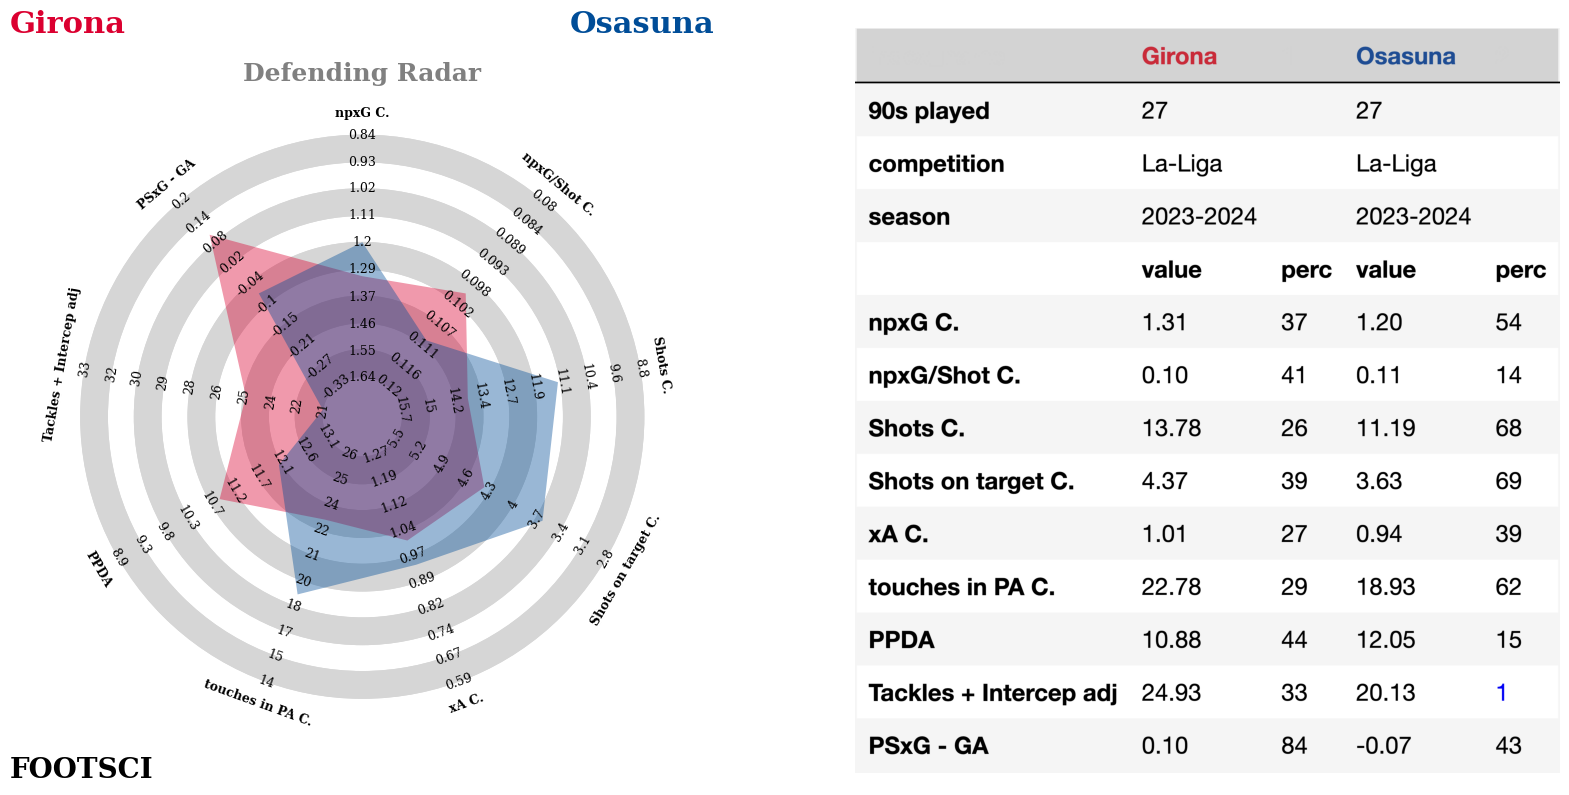

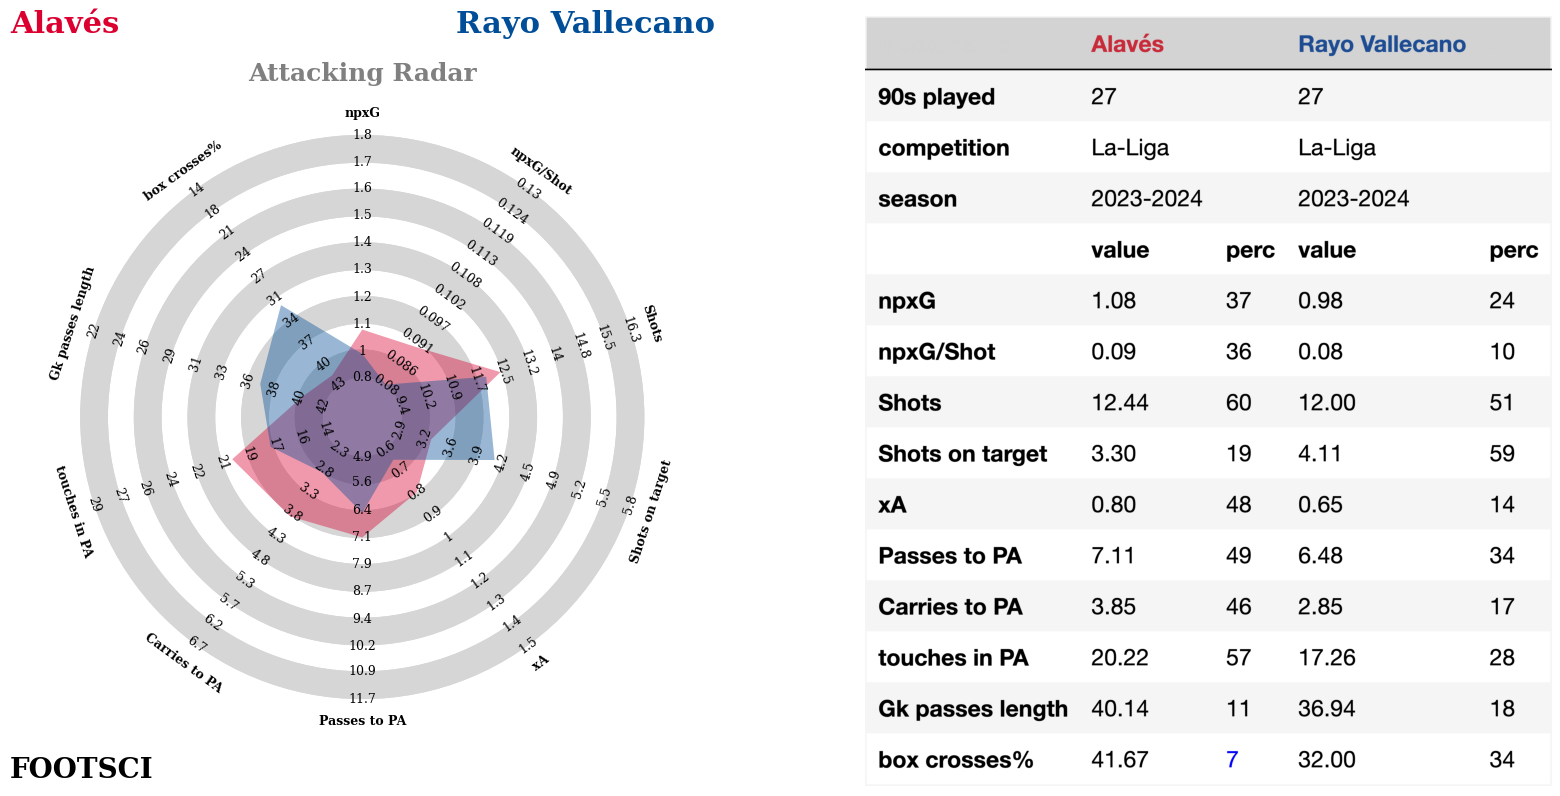

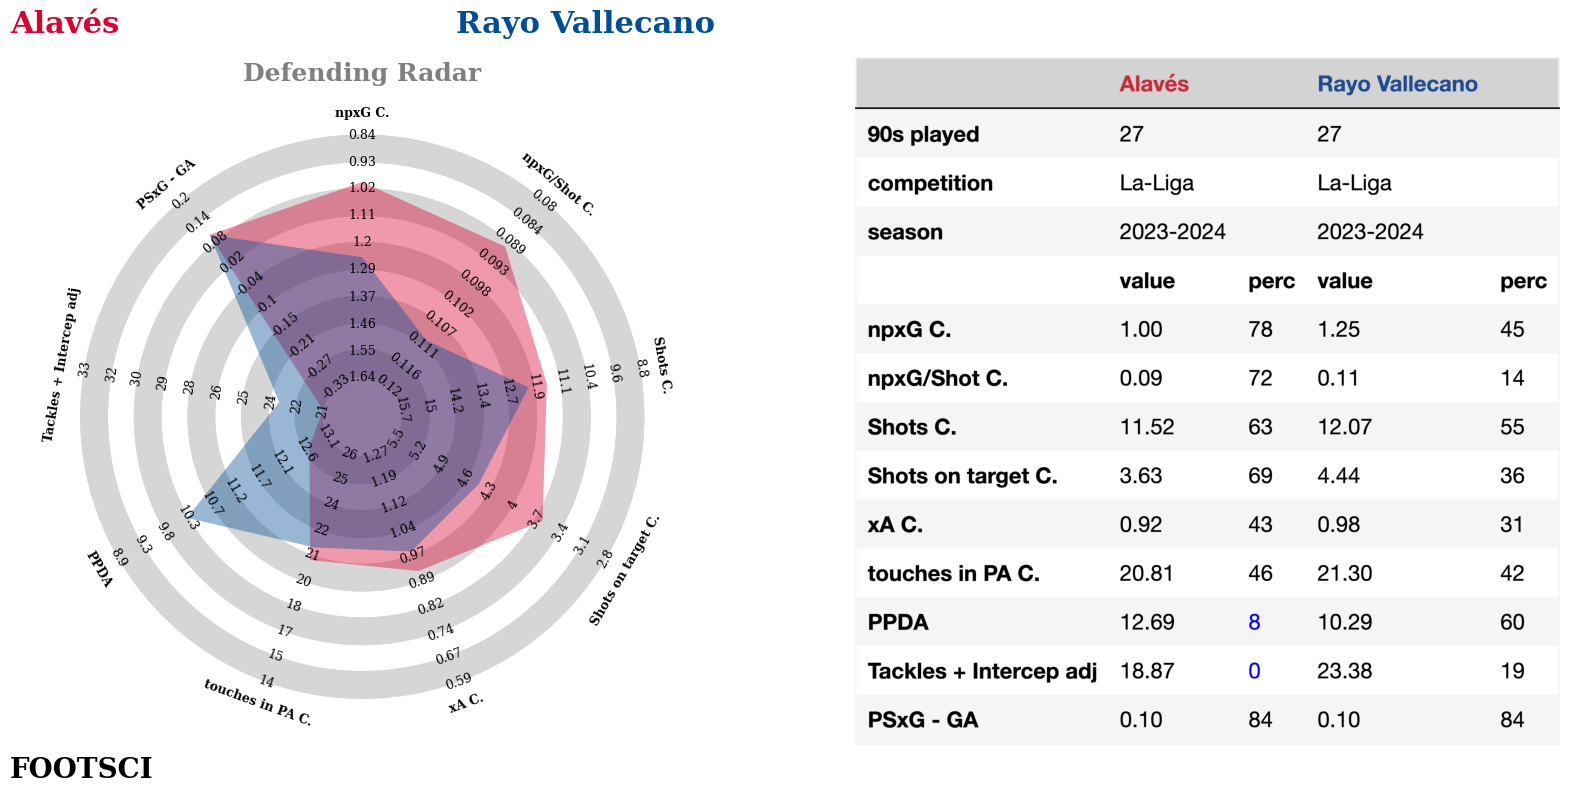

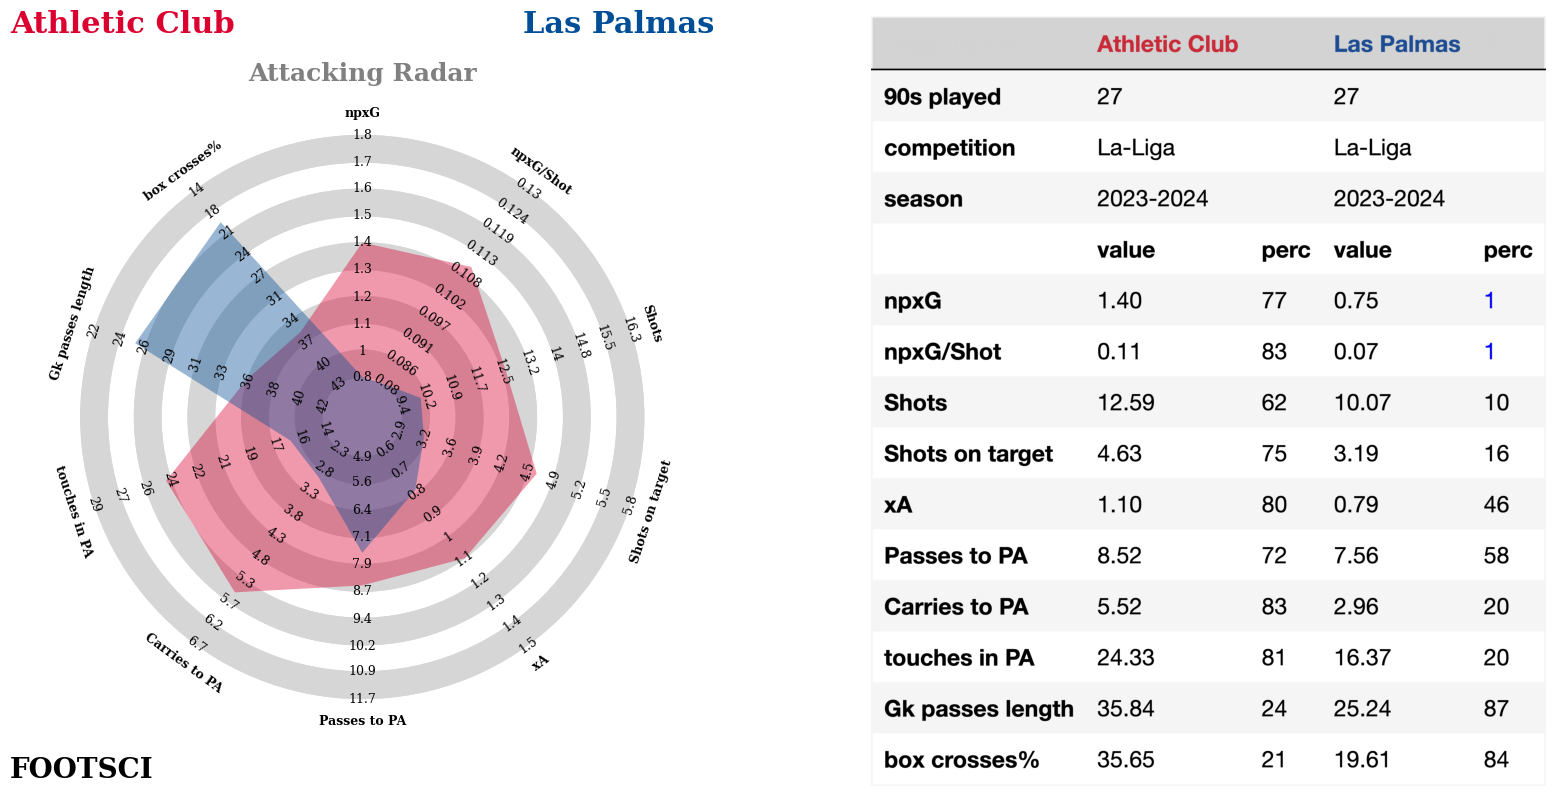

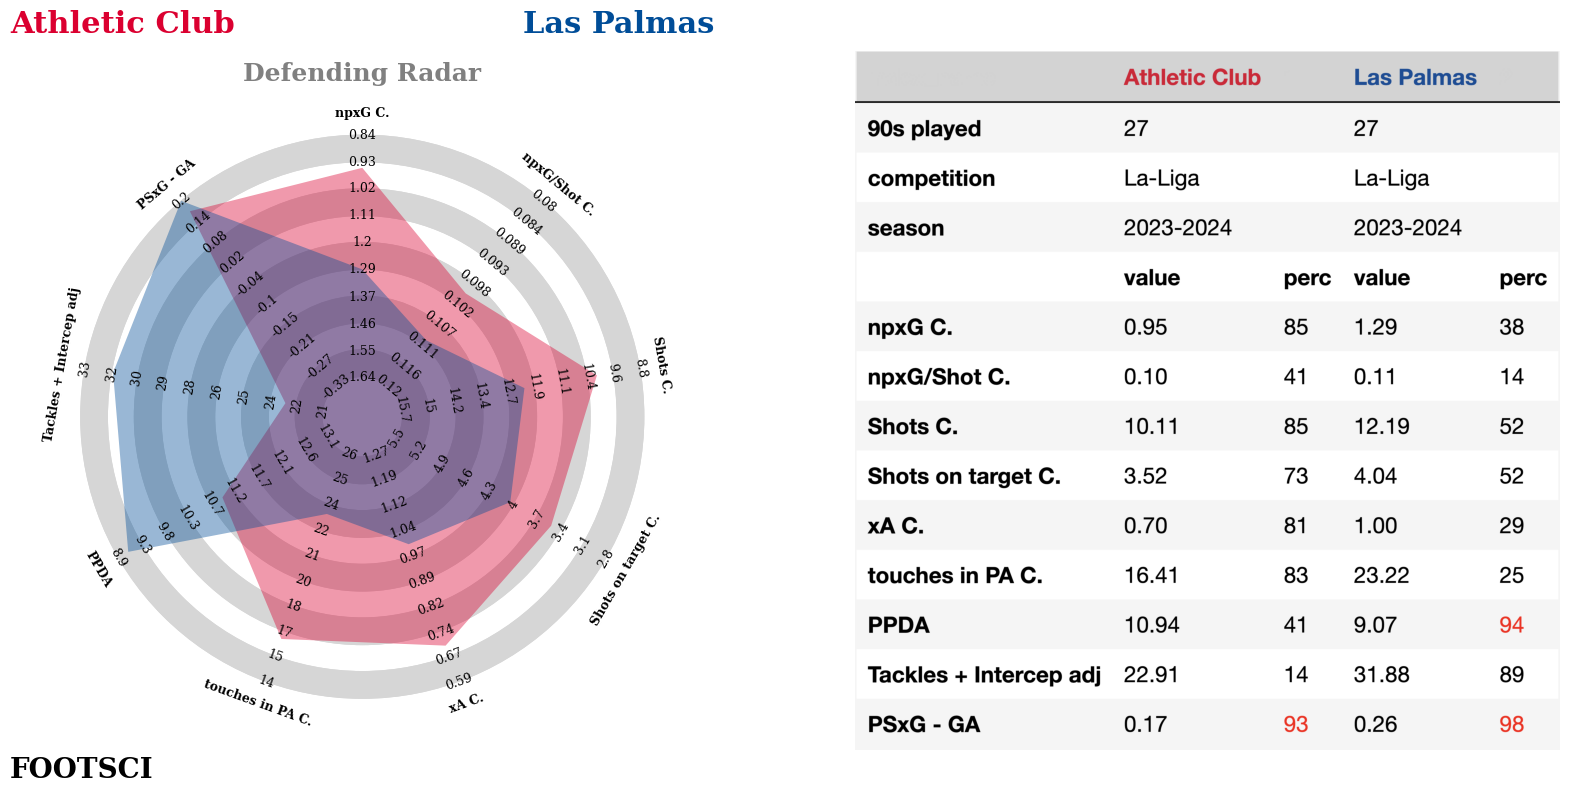

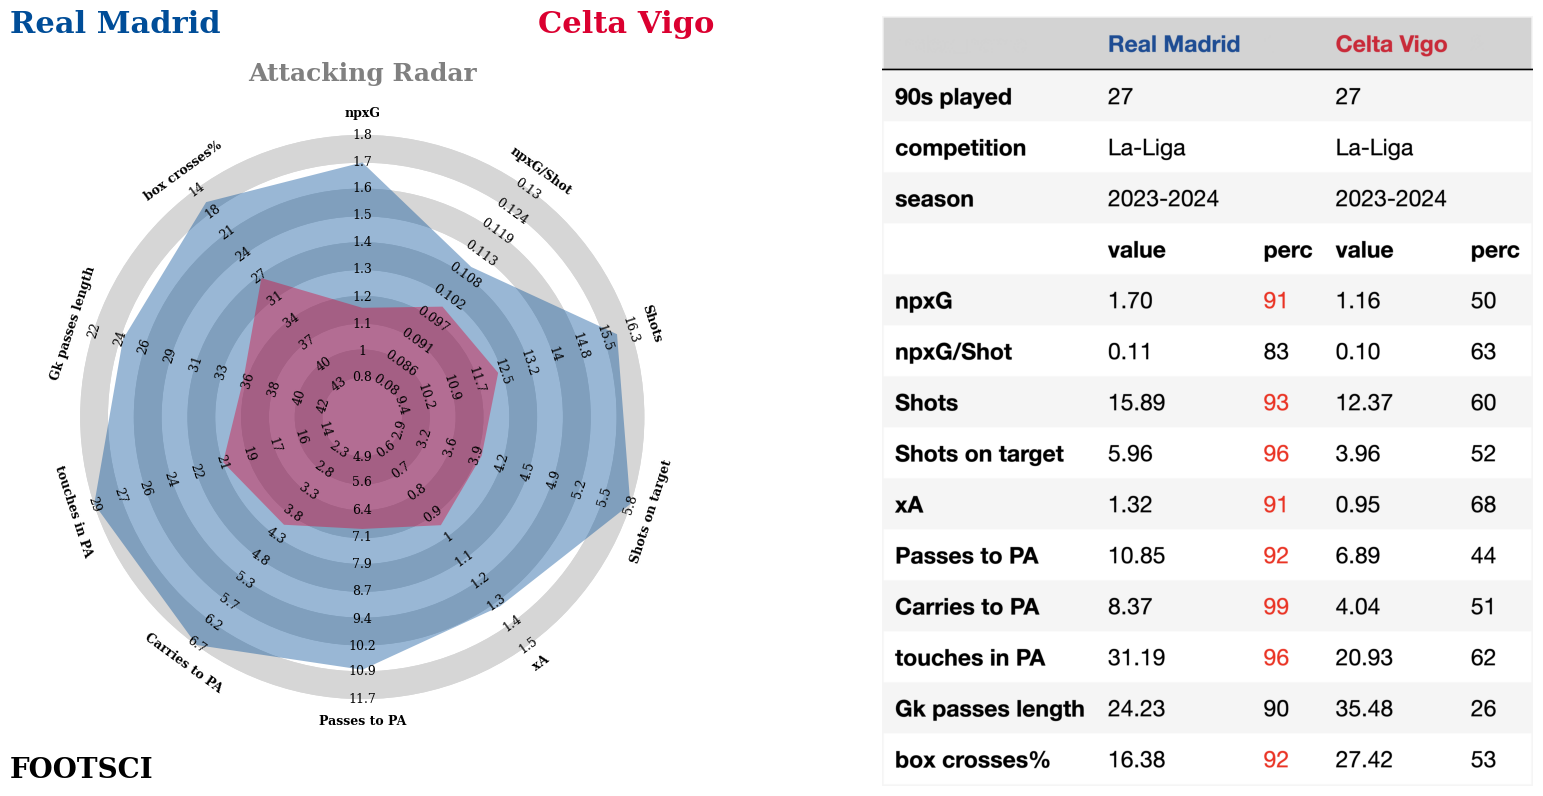

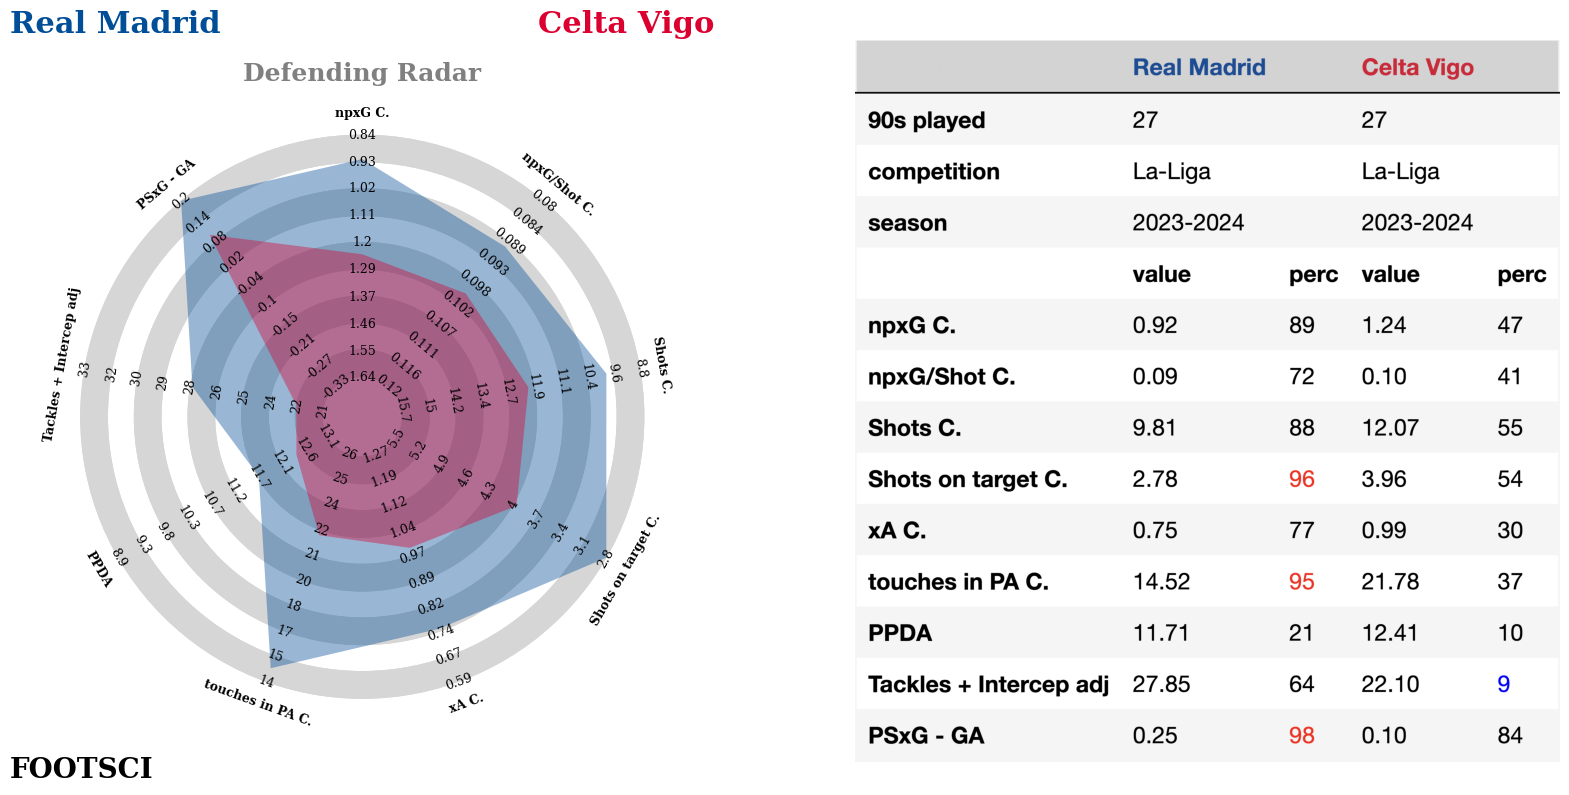

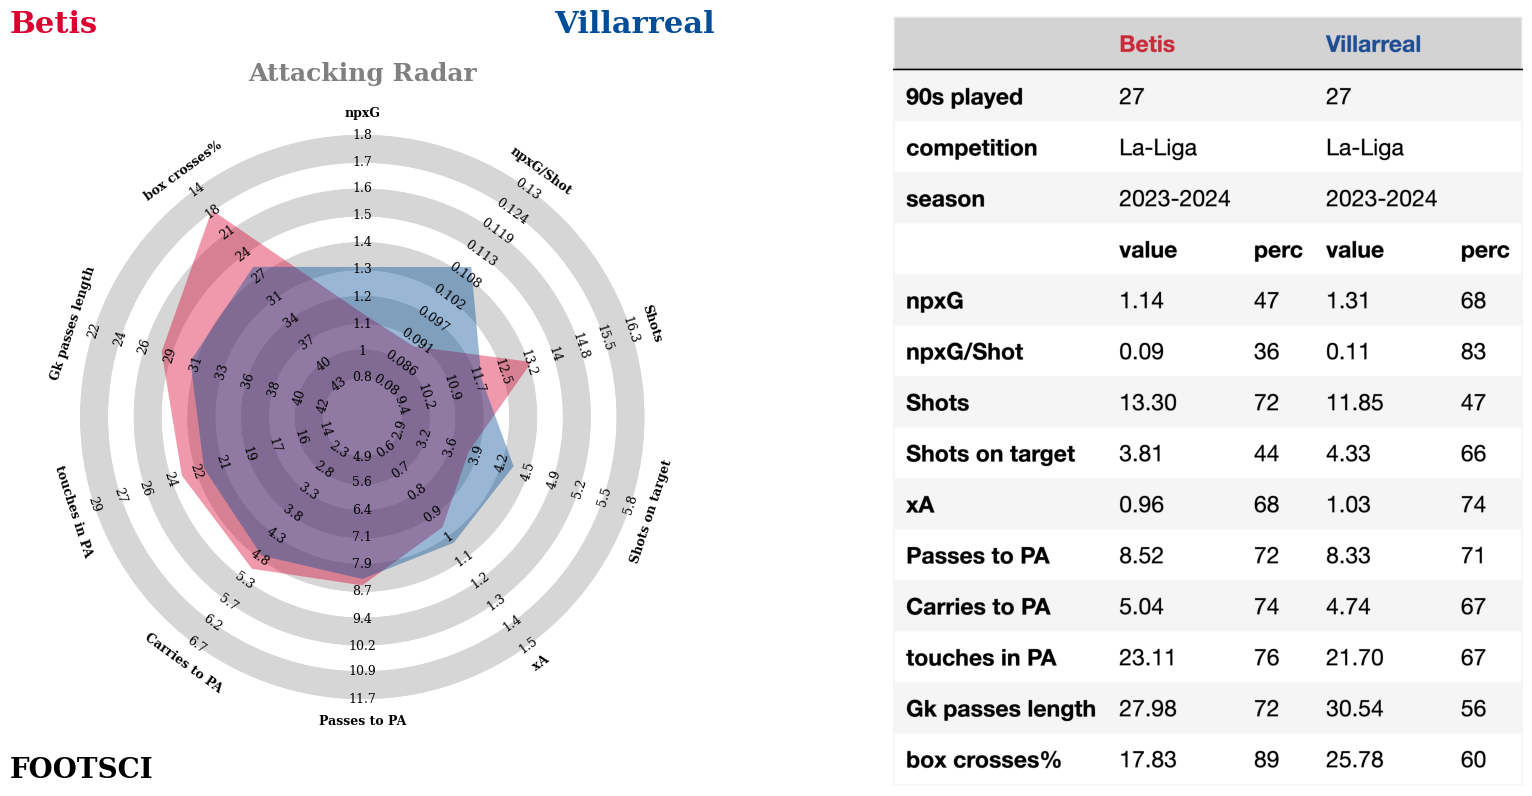

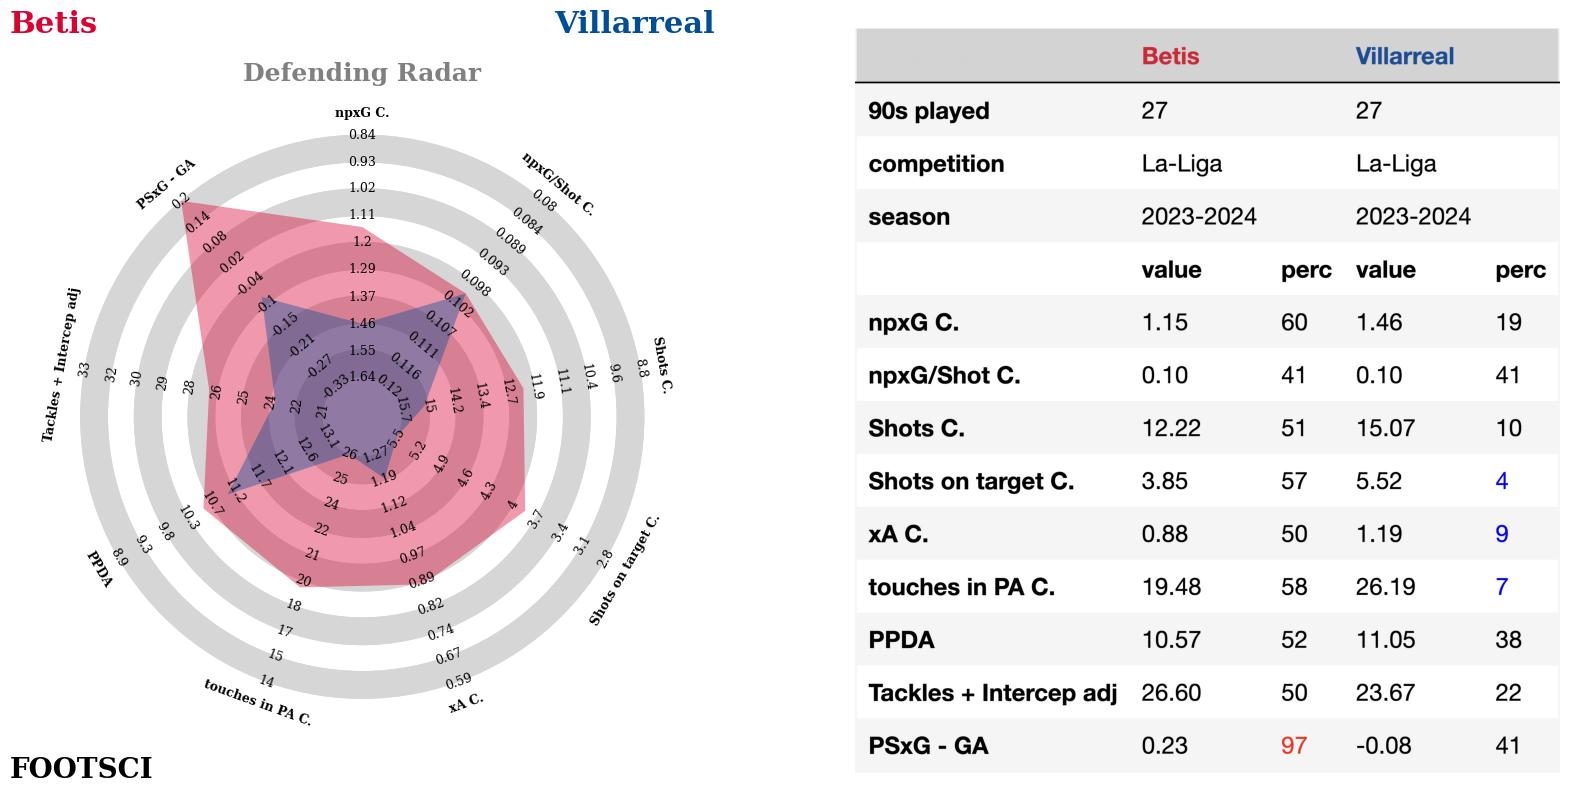

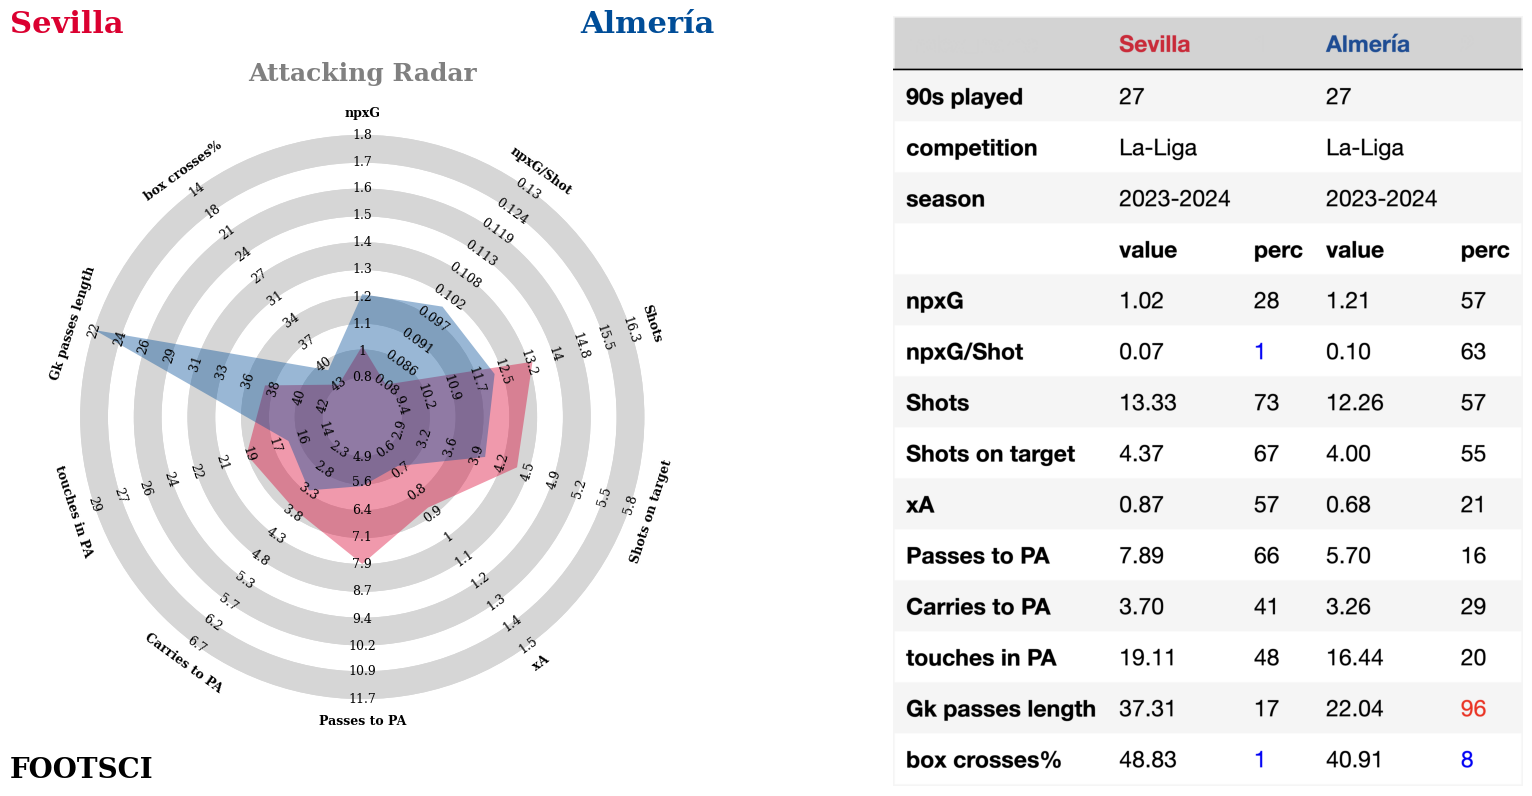

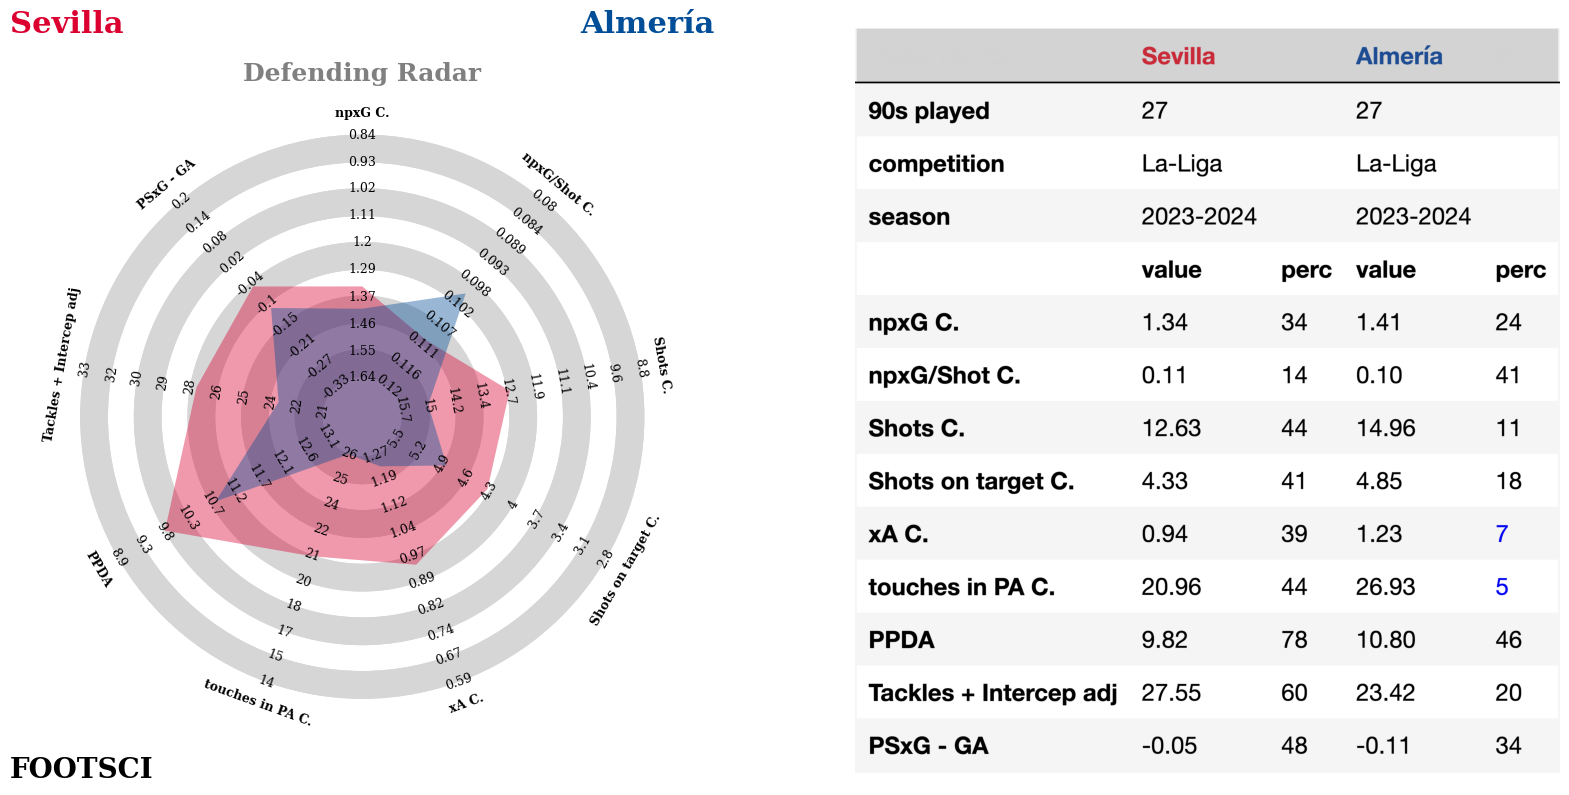

In [83]:
for n, row in df_games.iterrows():

    
    team1 = row['home_team']
    team2 = row['away_team']
    
    radar_order = []
    
    for rt in ['Attacking Radar', 'Defending Radar']:

        metric_dict = dict_m[rt]['metric_dict']
        metric_to_plot = dict_m[rt]['metric_to_plot']

        if rt == 'Attacking Radar':

            df_metrics = get_df_metrics(df_team, df_team_old, team1, team2, metric_dict, metric_to_plot)
            df_metrics_v2 = preprocessing_df_metric(df_metrics, df_team, rt)
            image = metrics_to_image(df_metrics_v2, color_dict, rt, date)
            plot_radar(df_metrics, df_metrics_v2, rt, color_dict, date, image)
            team1 = df_metrics_v2.columns[0]
            team2 = df_metrics_v2.columns[2]
            radar_order.append(team1)
            radar_order.append(team2)
        else:
            df_metrics = get_df_metrics(df_team_vs, df_team_vs_old, team1, team2, metric_dict, metric_to_plot)
            df_metrics_v2 = preprocessing_df_metric(df_metrics, df_team, rt, radar_order = radar_order)
            image = metrics_to_image(df_metrics_v2, color_dict, rt, date)
            plot_radar(df_metrics, df_metrics_v2, rt, color_dict, date, image, radar_order = radar_order)
